<a id='top'></a>

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# %matplotlib nbagg 
%matplotlib notebook
# %matplotlib inline



## Third party 
import numpy as np
import os, time, zarr, sys
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

import unslice.IO as io
from unslice.utils import *
from unslice.registration.featmatch import *
from unslice.registration.transform import *
from unslice.registration.rigid import *
from unslice.registration.gpu_transform import *
from unslice.registration.utils import *
from unslice.segmentation import *
from unslice.tracing.pyoof import OOF, apply_oof_v2
from unslice.tracing.skel import *
from unslice.flatten import *
from unslice.lightsheetcorrect import *




In [2]:
# Parameters that are constant throughout notebook
working_dir = '/mnt/beegfs/webster/fig2_coronal' 

def bdir(fname):
    return os.path.join(working_dir, fname)

# prefix to add to the beginning of each filename 
name_prefix = 'top'
name_prefix2 = 'bot'

# Read using DANDI
urls = [
      "file:///mnt/beegfs/Lee/dandi/sub-MITU01h3/ses-20211206h15m58s41/microscopy/sub-MITU01h3_ses-20211206h15m58s41_run-1_sample-20_stain-LEC_chunk-1_spim.ngff",
      "file:///mnt/beegfs/Lee/dandi/sub-MITU01h3/ses-20211206h15m58s41/microscopy/sub-MITU01h3_ses-20211206h15m58s41_run-1_sample-20_stain-LEC_chunk-2_spim.ngff",
      "file:///mnt/beegfs/Lee/dandi/sub-MITU01h3/ses-20211206h15m58s41/microscopy/sub-MITU01h3_ses-20211206h15m58s41_run-1_sample-20_stain-LEC_chunk-3_spim.ngff",
      "file:///mnt/beegfs/Lee/dandi/sub-MITU01h3/ses-20211206h15m58s41/microscopy/sub-MITU01h3_ses-20211206h15m58s41_run-1_sample-20_stain-LEC_chunk-4_spim.ngff",
      "file:///mnt/beegfs/Lee/dandi/sub-MITU01h3/ses-20211206h15m58s41/microscopy/sub-MITU01h3_ses-20211206h15m58s41_run-1_sample-20_stain-LEC_chunk-5_spim.ngff",
      "file:///mnt/beegfs/Lee/dandi/sub-MITU01h3/ses-20211206h15m58s41/microscopy/sub-MITU01h3_ses-20211206h15m58s41_run-1_sample-20_stain-LEC_chunk-6_spim.ngff"
    ]

# Table of contents

### Pre-processing
[1. Convert to zarr](#convert)<br>
[2. Downsample](#downsample)<br>
[3. Segment](#segment)<br>
[4. Surface detection](#surfdetect)<br>
[5. Background correction](#background)<br>

### Endpoint detection
[5. Vessel filter](#oof)<br>
[6. Vessel segment](#vessel_segment)<br>
[7. Vessel skeletonization](#skel)<br>
[8. Vessel endpoint detection](#epdetect)<br>

### Surface flattening 
[9. Sample surface](#flatten)<br>
[10. Surface outlier removal](#outlier_surf)<br>
[11. UV map](#uvmap)<br>
[12. Rigid align UV maps](#uvuvalign)<br>
[13. Flatten warp](#flattenwarp)<br>

### Transformation (round 1)
[13. Rigid transformation based on manual anchor points](#rigidanchor)<br>
[14. TPS transformation based on manual anchor points](#anchorwarp)<br>
[15. Feature match](#featmatch)<br>
[16. TPS transformation round 1](#tpswarp)<br>

### Transformation (more rounds)
[17. TPS transformation round 2](#tpsr2)<br>
[18. TPS transformation round 3](#tps3)<br>

### Tests
[Tests](#tests)<br>

# Convert to zarr
<a id='convert'></a>

[Return to top](#top)

In [3]:
# Top slab coordinates
## I think the bottom of the top slab goes with the top of the bottom slab ... 
x0 = 900; x1 = 12900
y0 = 400; y1 = 5400
z0 = 700; z1 = 1300

sink_zarr_path = bdir(name_prefix+'.zarr')
#resample_factor = (2.444/3.6544, 1.0, 2.444/3.6544)
resample_factor = None
chunks = (200,)*3
num_workers = 24

dandi2zarr(urls, [x0,x1],[y0,y1],[z0,z1],sink_zarr_path, resample_factor=resample_factor, chunks=chunks, num_workers=num_workers)

100%|██████████| 4500/4500 [1:30:56<00:00,  1.21s/it]  


In [4]:
# Bottom slab coordinates
x0 = 2300; x1 = 12700
y0 = 6550; y1 = 10750
z0 = 650; z1 = 1250


sink_zarr_path = bdir(name_prefix2+'.zarr')
#resample_factor = (2.444/3.6544, 1.0, 2.444/3.6544)
resample_factor = None
chunks = (200,)*3
num_workers = 24

dandi2zarr(urls, [x0,x1],[y0,y1],[z0,z1],sink_zarr_path, resample_factor=resample_factor, chunks=chunks, num_workers=num_workers)

100%|██████████| 3276/3276 [1:08:06<00:00,  1.25s/it]  


# Downsample 

<a id='downsample'></a>

[Return to top](#top)

In [8]:
# top 

source_zarr_path = bdir(name_prefix+'.zarr')
sink_zarr_path = bdir(name_prefix+'_downsampled.zarr')
resample_factor = (0.05, 0.05, 1.0)
chunks = 3*(200,)
num_workers = 24


#####
resample_zarr(source_zarr_path, sink_zarr_path, resample_factor,num_workers=num_workers)

100%|██████████| 4500/4500 [21:04<00:00,  3.56it/s]


In [9]:
z = zarr.open(bdir(name_prefix+'_downsampled.zarr'), mode='r')
img = z[:]
io.writeData(bdir(name_prefix+'_downsampled.tif'), img)

'/mnt/beegfs/webster/fig2_coronal/top_downsampled.tif'

In [10]:
# bottom

source_zarr_path = bdir(name_prefix2+'.zarr')
sink_zarr_path = bdir(name_prefix2+'_downsampled.zarr')
resample_factor = (0.05, 0.05, 1.0)
chunks = 3*(200,)
num_workers = 24


#####
resample_zarr(source_zarr_path, sink_zarr_path, resample_factor,num_workers=num_workers)

100%|██████████| 3276/3276 [13:55<00:00,  3.92it/s]


In [11]:
z = zarr.open(bdir(name_prefix2+'_downsampled.zarr'), mode='r')
img = z[:]
io.writeData(bdir(name_prefix2+'_downsampled.tif'), img)

'/mnt/beegfs/webster/fig2_coronal/bot_downsampled.tif'

In [6]:
io.writeData(bdir(name_prefix+'_downsampled.tif'), img)

'/mnt/beegfs/webster/fig2_coronal/top_downsampled.tif'

### Change chunk size 

In [4]:
# Top 
source_zarr_path = bdir(name_prefix+'_downsampled.zarr')
sink_zarr_path = bdir(name_prefix+'_downsampled_.zarr')
new_chunks = 3*(200,)
num_workers = 24

convert_zarr_chunks(source_zarr_path, sink_zarr_path, new_chunks, num_workers=num_workers)


100%|██████████| 18/18 [05:15<00:00, 13.66s/it]


In [5]:
# Bottom 
source_zarr_path = bdir(name_prefix2+'_downsampled.zarr')
sink_zarr_path = bdir(name_prefix2+'_downsampled_.zarr')
new_chunks = 3*(200,)
num_workers = 24

convert_zarr_chunks(source_zarr_path, sink_zarr_path, new_chunks, num_workers=num_workers)


100%|██████████| 18/18 [04:12<00:00,  7.33s/it]


# Surface detection

## Tissue segmentation
<a id='segment'></a>
[Return to top](#top)

### Top

In [3]:
# Top 
# Parameters to be varied
sample_coord_ranges = [[[0,600],[0,250],[0,600]]]
min_thresholds = [150,200]#*3 # gets rid of background. Pick more or less stringent ones 
saturate_image_thresholds = [400,400] # saturate image threshold
morphopts = [None]*2 #[('close','ball',2)]*3

In [4]:
for i in range(len(min_thresholds)):
    opts = {
        'min_threshold' : min_thresholds[i], # This sets a minimum intensity threshold for pixels, choose this so that most background that is not tissue is eliminated
        'saturate_image_threshold' : saturate_image_thresholds[i], # if <1, then is a percent of pixels to saturate 
        'k' : 2,
        'alpha' : 25, # make this very high for high smoothness 
        'num_workers' : 24,
        'overlap' : 0,
        'morphopts' : morphopts[i],
        'sample_coord_ranges' :  sample_coord_ranges # Change this if we want to sample a few slices and see if it's worth processing whole data set on that 
        }
    zarr_path = bdir(name_prefix+'_downsampled_.zarr')
    zarr_segmented_path = bdir('surf_segmentation_tests/segmenttest.zarr')

    start = time.time()
    zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)
    print("Time elapsed: %f minutes"%((time.time()-start)/60))

Starting image preprocessing..
Saturated image processed in 0.388480 minutes


100%|██████████| 4500/4500 [13:29<00:00,  3.22it/s]


Display in Nuggt by doing !{cmd}: 
nuggt-display /mnt/beegfs/webster/fig2_coronal/surf_segmentation_tests/segmenttest_thresh150-400_x0_600_y0_250_z0_600_original.tif original red /mnt/beegfs/webster/fig2_coronal/surf_segmentation_tests/segmenttest_thresh150-400_x0_600_y0_250_z0_600_segmented.tif segged green --ip-address 10.93.6.101 --port=8900
Time elapsed: 23.486946 minutes
Starting image preprocessing..
Saturated image processed in 0.378317 minutes


100%|██████████| 4500/4500 [15:17<00:00,  4.90it/s]


Display in Nuggt by doing !{cmd}: 
nuggt-display /mnt/beegfs/webster/fig2_coronal/surf_segmentation_tests/segmenttest_thresh200-400_x0_600_y0_250_z0_600_original.tif original red /mnt/beegfs/webster/fig2_coronal/surf_segmentation_tests/segmenttest_thresh200-400_x0_600_y0_250_z0_600_segmented.tif segged green --ip-address 10.93.6.101 --port=8900
Time elapsed: 25.020644 minutes


In [6]:
opts = {
    'min_threshold' : 200, # This sets a minimum intensity threshold for pixels 
    'saturate_image_threshold' : 400,
    'k' : 2,
    'alpha' : 25,
    'num_workers' : 24,
    'overlap' : 0,
    'morphopts' : None, # ('dilate','ball',2),
    'sample_coord_ranges' : None
    }
zarr_path = bdir(name_prefix+'_downsampled_.zarr')
zarr_segmented_path = bdir(name_prefix+'_downsampled_segmented.zarr')

start = time.time()
zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)
print("Time elapsed: %f minutes"%((time.time()-start)/60))

Starting image preprocessing..
Saturated image processed in 0.024856 minutes



100%|██████████| 18/18 [00:26<00:00,  1.48s/it]

Time elapsed: 0.807266 minutes


### Bottom

In [5]:
# Bottom
# Parameters to be varied
sample_coord_ranges = [[[0,520],[0,210],[0,600]]]
min_thresholds = [150,200]#*3 # gets rid of background. Pick more or less stringent ones 
saturate_image_thresholds = [400,400] # saturate image threshold
morphopts = [None]*2 #[('close','ball',2)]*3

In [6]:
for i in range(len(min_thresholds)):
    opts = {
        'min_threshold' : min_thresholds[i], # This sets a minimum intensity threshold for pixels, choose this so that most background that is not tissue is eliminated
        'saturate_image_threshold' : saturate_image_thresholds[i], # if <1, then is a percent of pixels to saturate 
        'k' : 2,
        'alpha' : 25, # make this very high for high smoothness 
        'num_workers' : 24,
        'overlap' : 0,
        'morphopts' : morphopts[i],
        'sample_coord_ranges' :  sample_coord_ranges # Change this if we want to sample a few slices and see if it's worth processing whole data set on that 
        }
    zarr_path = bdir(name_prefix2+'_downsampled_.zarr')
    zarr_segmented_path = bdir('surf_segmentation_tests/segmenttest.zarr')

    start = time.time()
    zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)
    print("Time elapsed: %f minutes"%((time.time()-start)/60))

Starting image preprocessing..
Saturated image processed in 0.302893 minutes


100%|██████████| 3276/3276 [07:28<00:00,  4.92it/s]


Display in Nuggt by doing !{cmd}: 
nuggt-display /mnt/beegfs/webster/fig2_coronal/surf_segmentation_tests/segmenttest_thresh150-400_x0_520_y0_210_z0_600_original.tif original red /mnt/beegfs/webster/fig2_coronal/surf_segmentation_tests/segmenttest_thresh150-400_x0_520_y0_210_z0_600_segmented.tif segged green --ip-address 10.93.6.101 --port=8900
Time elapsed: 15.545768 minutes
Starting image preprocessing..
Saturated image processed in 0.287475 minutes


100%|██████████| 3276/3276 [07:25<00:00,  7.35it/s]


Display in Nuggt by doing !{cmd}: 
nuggt-display /mnt/beegfs/webster/fig2_coronal/surf_segmentation_tests/segmenttest_thresh200-400_x0_520_y0_210_z0_600_original.tif original red /mnt/beegfs/webster/fig2_coronal/surf_segmentation_tests/segmenttest_thresh200-400_x0_520_y0_210_z0_600_segmented.tif segged green --ip-address 10.93.6.101 --port=8900
Time elapsed: 15.709182 minutes


In [7]:
opts = {
    'min_threshold' : 200, # This sets a minimum intensity threshold for pixels 
    'saturate_image_threshold' : 400,
    'k' : 2,
    'alpha' : 25,
    'num_workers' : 24,
    'overlap' : 0,
    'morphopts' : None, #('dilate','ball',2),
    'sample_coord_ranges' : None
    }
zarr_path = bdir(name_prefix2+'_downsampled_.zarr')
zarr_segmented_path = bdir(name_prefix2+'_downsampled_segmented.zarr')

start = time.time()
zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)
print("Time elapsed: %f minutes"%((time.time()-start)/60))

Starting image preprocessing..
Saturated image processed in 0.019217 minutes



100%|██████████| 18/18 [00:26<00:00,  1.49s/it]

Time elapsed: 0.678546 minutes


# Surface detection

<a id='surfdetect'></a>

[Return to top](#top)

### Top

#### Top surface

In [14]:
# Find the top surface 
segmented_zarr_path = bdir(name_prefix+'_downsampled_segmented.zarr')
surf_zarr_path = bdir(name_prefix+'_downsampled_surface_top.zarr')
slices_to_search = [20,600]#[20,300]
num_slices_to_add = 10 # make low if we're just sampling points on the surface 
num_slices_above = False # if True, then add in pixels above surface to check for endpoints 
orientation = 'ztop'
use_full_image = True
thin_surf_zarr_path = bdir(name_prefix+'_downsampled_thinsurface_top.zarr')# default None, need a path here if we want to do new method 



#########
start = time.time()
mask2surf_zarr(segmented_zarr_path, surf_zarr_path, slices_to_search,
               num_slices_to_add, num_slices_above, orientation=orientation, use_full_image=use_full_image,
              thin_surf_zarr_path=thin_surf_zarr_path)
print("Time elapsed: %f minutes"%((time.time()-start)/60))

100%|██████████| 580/580 [00:02<00:00, 212.99it/s]


Time elapsed: 0.177687 minutes


In [15]:
z = zarr.open(surf_zarr_path,mode='r')
io.writeData(surf_zarr_path[:-4]+'tif', z[:])

'/mnt/beegfs/webster/fig2_coronal/top_downsampled_surface_top.tif'

In [3]:
# Filter based on manual contour detection
contour_pts_path = bdir('manual_anchor_labels/fig2_20220315_ogframe_surf_top_top_concavehull.json')
json_name = 'top_concave_hull' # if contour_pts_path is json, then we need a channel name for the annotations
surf_zarr_paths = [bdir(name_prefix+'_downsampled_surface_top.zarr'),
                  bdir(name_prefix+'_downsampled_thinsurface_top.zarr')]
surf_zarr_save_paths = [bdir(name_prefix+'_downsampled_surface_top_polygon.zarr'),
                      bdir(name_prefix+'_downsampled_thinsurface_top_polygon.zarr')]
downsample_factor = 20
polygon_save_path = bdir(name_prefix+'_top_polygon.tif')

surfs = polygon_mask_surface(contour_pts_path, surf_zarr_paths, json_name=json_name, downsample_factor=downsample_factor,
                         surf_zarr_save_paths=surf_zarr_save_paths, polygon_save_path=polygon_save_path)

In [4]:
for s in surf_zarr_save_paths:
    z = zarr.open(s,mode='r')
    io.writeData(s[:-4]+'tif', z[:])

#### Bottom surface

In [16]:
# Find the bottom surface 
segmented_zarr_path = bdir(name_prefix+'_downsampled_segmented.zarr')
surf_zarr_path = bdir(name_prefix+'_downsampled_surface_bottom.zarr')
slices_to_search = [20,600]#[400,600]
num_slices_to_add = 10 # make low if we're just sampling points on the surface 
num_slices_above = False # if True, then add in pixels above surface to check for endpoints 
orientation = 'zbottom'
use_full_image = True
thin_surf_zarr_path = bdir(name_prefix+'_downsampled_thinsurface_bottom.zarr')# default None, need a path here if we want to do new method 



#########
start = time.time()
mask2surf_zarr(segmented_zarr_path, surf_zarr_path, slices_to_search,
               num_slices_to_add, num_slices_above, orientation=orientation, use_full_image=use_full_image,
              thin_surf_zarr_path=thin_surf_zarr_path)
print("Time elapsed: %f minutes"%((time.time()-start)/60))

100%|██████████| 580/580 [00:02<00:00, 224.95it/s]


Time elapsed: 0.111709 minutes


In [17]:
# z = zarr.open(surf_zarr_path,mode='r')
# io.writeData(surf_zarr_path[:-4]+'tif', z[:])

'/mnt/beegfs/webster/fig2_coronal/top_downsampled_surface_bottom.tif'

In [5]:
# Filter based on manual contour detection
contour_pts_path = bdir('manual_anchor_labels/fig2_20220315_ogframe_surf_top_top_concavehull.json')
json_name = 'top_bottom_concavehull' # if contour_pts_path is json, then we need a channel name for the annotations
surf_zarr_paths = [bdir(name_prefix+'_downsampled_surface_bottom.zarr'),
                  bdir(name_prefix+'_downsampled_thinsurface_bottom.zarr')]
surf_zarr_save_paths = [bdir(name_prefix+'_downsampled_surface_bottom_polygon.zarr'),
                      bdir(name_prefix+'_downsampled_thinsurface_bottom_polygon.zarr')]
downsample_factor = 20
polygon_save_path = bdir(name_prefix+'_bottom_polygon.tif')

surfs = polygon_mask_surface(contour_pts_path, surf_zarr_paths, json_name=json_name, downsample_factor=downsample_factor,
                         surf_zarr_save_paths=surf_zarr_save_paths, polygon_save_path=polygon_save_path)

In [6]:
for s in surf_zarr_save_paths:
    z = zarr.open(s,mode='r')
    io.writeData(s[:-4]+'tif', z[:])

### Bottom

#### Top surface

In [18]:
# Find the top surface 
segmented_zarr_path = bdir(name_prefix2+'_downsampled_segmented.zarr')
surf_zarr_path = bdir(name_prefix2+'_downsampled_surface_top.zarr')
slices_to_search = [50,560]#[50,400]
num_slices_to_add = 10 # make low if we're just sampling points on the surface 
num_slices_above = False # if True, then add in pixels above surface to check for endpoints 
orientation = 'ztop'
use_full_image = True
thin_surf_zarr_path = bdir(name_prefix2+'_downsampled_thinsurface_top.zarr')# default None, need a path here if we want to do new method 



#########
start = time.time()
mask2surf_zarr(segmented_zarr_path, surf_zarr_path, slices_to_search,
               num_slices_to_add, num_slices_above, orientation=orientation, use_full_image=use_full_image,
              thin_surf_zarr_path=thin_surf_zarr_path)
print("Time elapsed: %f minutes"%((time.time()-start)/60))

100%|██████████| 510/510 [00:01<00:00, 318.41it/s]


Time elapsed: 0.176976 minutes


In [19]:
z = zarr.open(surf_zarr_path,mode='r')
io.writeData(surf_zarr_path[:-4]+'tif', z[:])

'/mnt/beegfs/webster/fig2_coronal/bot_downsampled_surface_top.tif'

In [29]:
# Filter based on manual contour detection
contour_pts_path = bdir('manual_anchor_labels/bot_top_concavehull_pts.json')
json_name = 'bot_top_concavehull' # if contour_pts_path is json, then we need a channel name for the annotations
surf_zarr_paths = [bdir(name_prefix2+'_downsampled_surface_top.zarr'),
                  bdir(name_prefix2+'_downsampled_thinsurface_top.zarr')]
surf_zarr_save_paths = [bdir(name_prefix2+'_downsampled_surface_top_polygon.zarr'),
                      bdir(name_prefix2+'_downsampled_thinsurface_top_polygon.zarr')]
downsample_factor = 20
polygon_save_path = bdir(name_prefix2+'_top_polygon.tif')

surfs = polygon_mask_surface(contour_pts_path, surf_zarr_paths, json_name=json_name, downsample_factor=downsample_factor,
                         surf_zarr_save_paths=surf_zarr_save_paths, polygon_save_path=polygon_save_path)

In [30]:
for s in surf_zarr_save_paths:
    z = zarr.open(s,mode='r')
    io.writeData(s[:-4]+'tif', z[:])

#### Bottom surface

In [20]:
# Find the bottom surface 
segmented_zarr_path = bdir(name_prefix2+'_downsampled_segmented.zarr')
surf_zarr_path = bdir(name_prefix2+'_downsampled_surface_bottom.zarr')
slices_to_search = [50,560]#[350,560]
num_slices_to_add = 10 # make low if we're just sampling points on the surface 
num_slices_above = False # if True, then add in pixels above surface to check for endpoints 
orientation = 'zbottom'
use_full_image = True
thin_surf_zarr_path = bdir(name_prefix2+'_downsampled_thinsurface_bottom.zarr')# default None, need a path here if we want to do new method 



#########
start = time.time()
mask2surf_zarr(segmented_zarr_path, surf_zarr_path, slices_to_search,
               num_slices_to_add, num_slices_above, orientation=orientation, use_full_image=use_full_image,
              thin_surf_zarr_path=thin_surf_zarr_path)
print("Time elapsed: %f minutes"%((time.time()-start)/60))

100%|██████████| 510/510 [00:01<00:00, 331.04it/s]


Time elapsed: 0.108886 minutes


In [21]:
z = zarr.open(surf_zarr_path,mode='r')
io.writeData(surf_zarr_path[:-4]+'tif', z[:])

'/mnt/beegfs/webster/fig2_coronal/bot_downsampled_surface_bottom.tif'

In [31]:
# Filter based on manual contour detection
contour_pts_path = bdir('manual_anchor_labels/bot_top_concavehull_pts.json')
json_name = 'bot_bottom_concavehull' # if contour_pts_path is json, then we need a channel name for the annotations
surf_zarr_paths = [bdir(name_prefix2+'_downsampled_surface_bottom.zarr'),
                  bdir(name_prefix2+'_downsampled_thinsurface_bottom.zarr')]
surf_zarr_save_paths = [bdir(name_prefix2+'_downsampled_surface_bottom_polygon.zarr'),
                      bdir(name_prefix2+'_downsampled_thinsurface_bottom_polygon.zarr')]
downsample_factor = 20
polygon_save_path = bdir(name_prefix2+'_bottom_polygon.tif')

surfs = polygon_mask_surface(contour_pts_path, surf_zarr_paths, json_name=json_name, downsample_factor=downsample_factor,
                         surf_zarr_save_paths=surf_zarr_save_paths, polygon_save_path=polygon_save_path)

In [32]:
for s in surf_zarr_save_paths:
    z = zarr.open(s,mode='r')
    io.writeData(s[:-4]+'tif', z[:])

# Background correction

[Return to top](#top)

<a id='background'></a>

In [4]:
source_zarr_path = bdir(name_prefix+'.zarr')
sink_zarr_path = bdir(name_prefix+'_illumcorr.zarr')
num_workers = 24

background_correct_args = {'percentile': 0.5,
          'background': dict(selem=(100,100,1)),
          'factor': 1.5
          }



######################
# parallel_zarr_correct(correct_background, source_zarr_path, sink_zarr_path,
#                       num_workers=num_workers, **background_correct_args)
start = time.time()
parallel_correct_background(source_zarr_path, sink_zarr_path, num_workers=num_workers, **background_correct_args)
print("Time elapsed:",time.time()-start,"seconds")

Working on z=0 to 200


100%|██████████| 200/200 [02:07<00:00,  1.41it/s]


Working on z=200 to 400


100%|██████████| 200/200 [02:09<00:00,  1.54it/s]


Working on z=400 to 600


100%|██████████| 200/200 [02:10<00:00,  1.79it/s]


Time elapsed: 4041.707325696945 seconds


In [5]:
# Check the quality
xr = [8000,9000]
yr = [2000,3000]
zr = [400,600]
save_path_filtered = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d_illumcorr.tif'%(name_prefix,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))
#save_path_og = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d.tif'%(name_prefix,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))


#####
z = zarr.open(bdir(name_prefix+'_illumcorr.zarr'), mode='r')
io.writeData(save_path_filtered, z[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]])

'/mnt/beegfs/webster/fig2_coronal/vessel_tests/top_x8000-9000_y2000-3000_z400-600_illumcorr.tif'

### Bottom

In [6]:
source_zarr_path = bdir(name_prefix2+'.zarr')
sink_zarr_path = bdir(name_prefix2+'_illumcorr.zarr')
num_workers = 24

background_correct_args = {'percentile': 0.5,
          'background': dict(selem=(100,100,1)),
          'factor': 1.5
          }



######################
# parallel_zarr_correct(correct_background, source_zarr_path, sink_zarr_path,
#                       num_workers=num_workers, **background_correct_args)
start = time.time()
parallel_correct_background(source_zarr_path, sink_zarr_path, num_workers=num_workers, **background_correct_args)
print("Time elapsed:",time.time()-start,"seconds")

Working on z=0 to 200


100%|██████████| 200/200 [01:35<00:00,  2.10it/s]


Working on z=200 to 400


100%|██████████| 200/200 [01:35<00:00,  1.92it/s]


Working on z=400 to 600


100%|██████████| 200/200 [01:37<00:00,  1.99it/s]


Time elapsed: 2101.3138563632965 seconds


In [7]:
# Check the quality
xr = [2000,3000]
yr = [2000,3000]
zr = [0,200]
save_path_filtered = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d_illumcorr.tif'%(name_prefix2,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))
#save_path_og = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d.tif'%(name_prefix2,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))


#####
z = zarr.open(sink_zarr_path,mode='r')
io.writeData(save_path_filtered, z[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]])

'/mnt/beegfs/webster/fig2_coronal/vessel_tests/bot_x2000-3000_y2000-3000_z0-200_illumcorr.tif'

# Endpoint detection

[Return to top](#top)

<a id='oof'></a>

## Object-oriented flux vesselness filter

### Top

In [8]:
## Parameters 
# First filter for the top 
radii = np.arange(1,8,1)
options = {'response_type': 0,
          'use_absolute': True,
          'normalization_type': 1,
          'spacing': (1,1.414,1),
          'calc_eigenvectors': False,
           'do_oofofa': False
          }
# Inputs
slab_zarr_path = bdir(name_prefix+'_illumcorr.zarr')

# Restrict detection to mask areas
mask_zarr_path = bdir(name_prefix+'_downsampled_surface_top.zarr')
downsample_factor = (20,20,1)

# Outputs
slab_zarr_filtered_path = bdir(name_prefix+'_oof_top.zarr')

# Optional
top_slice_range = None 
use_cupy = True
num_workers = 6 # using more than 6 is too memory intensive and will throw an error 

In [9]:
start = time.time()
apply_oof_v2(slab_zarr_path, slab_zarr_filtered_path, 
         radii, slice_range=top_slice_range, use_cupy=use_cupy,
         num_workers=num_workers, mask_zarr_path=mask_zarr_path,downsample_factor=downsample_factor,
             **options)
print("Time elapsed for OOF filtering: %f hours"%((time.time()-start)/3600))

Finding relevant chunks...


100%|██████████| 4500/4500 [00:58<00:00, 77.25it/s] 


Starting vessel filter...


100%|██████████| 921/921 [37:31<00:00,  2.11s/it]


Correcting blosc decompression errors...


100%|██████████| 4500/4500 [02:32<00:00, 29.53it/s]

0 chunks experienced errors
Time elapsed for OOF filtering: 0.687062 hours


In [10]:
# Check a small window 
xr = [4000,5000]
yr = [2000,3000]
zr = [0,200]
save_path_filtered = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d_filtered.tif'%(name_prefix,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))
save_path_og = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d.tif'%(name_prefix,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))

#################
# filtered
z = zarr.open(slab_zarr_filtered_path,mode='r')
img = z[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]]
io.writeData(save_path_filtered, img)

# original
za = zarr.open(slab_zarr_path, mode='r')
imga = za[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]]
io.writeData(save_path_og, imga)


'/mnt/beegfs/webster/fig2_coronal/vessel_tests/top_x4000-5000_y2000-3000_z0-200.tif'

In [11]:
## Parameters 
# Filter for bottom  
radii = np.arange(1,8,1)
options = {'response_type': 0,
          'use_absolute': True,
          'normalization_type': 1,
          'spacing': (1,1.414,1),
          'calc_eigenvectors': False,
           'do_oofofa': False
          }
# Inputs
slab_zarr_path = bdir(name_prefix+'_illumcorr.zarr')

# Restrict detection to mask areas
mask_zarr_path = bdir(name_prefix+'_downsampled_surface_bottom.zarr')
downsample_factor = (20,20,1)

# Outputs
slab_zarr_filtered_path = bdir(name_prefix+'_oof_bottom.zarr')

# Optional
top_slice_range = None 
use_cupy = True
num_workers = 6 # using more than 6 is too memory intensive and will throw an error 

In [12]:
start = time.time()
apply_oof_v2(slab_zarr_path, slab_zarr_filtered_path, 
         radii, slice_range=top_slice_range, use_cupy=use_cupy,
         num_workers=num_workers, mask_zarr_path=mask_zarr_path,downsample_factor=downsample_factor,
             **options)
print("Time elapsed for OOF filtering: %f hours"%((time.time()-start)/3600))

Finding relevant chunks...


100%|██████████| 4500/4500 [01:02<00:00, 72.02it/s] 


Starting vessel filter...


100%|██████████| 805/805 [36:46<00:00,  3.38s/it]


Correcting blosc decompression errors...


100%|██████████| 4500/4500 [02:23<00:00, 31.47it/s]


0 chunks experienced errors
Time elapsed for OOF filtering: 0.672468 hours


In [13]:
# Check a small window 
xr = [8000,9000]
yr = [2000,3000]
zr = [400,600]
save_path_filtered = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d_filtered.tif'%(name_prefix,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))
save_path_og = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d.tif'%(name_prefix,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))

#################
# filtered
z = zarr.open(slab_zarr_filtered_path,mode='r')
img = z[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]]
io.writeData(save_path_filtered, img)

# original
za = zarr.open(slab_zarr_path, mode='r')
imga = za[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]]
io.writeData(save_path_og, imga)


'/mnt/beegfs/webster/fig2_coronal/vessel_tests/top_x8000-9000_y2000-3000_z400-600.tif'

### Bottom

In [14]:
## Parameters 
# First filter for the top 
radii = np.arange(1,8,1)
options = {'response_type': 0,
          'use_absolute': True,
          'normalization_type': 1,
          'spacing': (1,1.414,1),
          'calc_eigenvectors': False,
           'do_oofofa': False
          }
# Inputs
slab_zarr_path = bdir(name_prefix2+'_illumcorr.zarr')

# Restrict detection to mask areas
mask_zarr_path = bdir(name_prefix2+'_downsampled_surface_top.zarr')
downsample_factor = (20,20,1)

# Outputs
slab_zarr_filtered_path = bdir(name_prefix2+'_oof_top.zarr')

# Optional
top_slice_range = None 
use_cupy = True
num_workers = 6 # using more than 6 is too memory intensive and will throw an error 

In [15]:
start = time.time()
apply_oof_v2(slab_zarr_path, slab_zarr_filtered_path, 
         radii, slice_range=top_slice_range, use_cupy=use_cupy,
         num_workers=num_workers, mask_zarr_path=mask_zarr_path,downsample_factor=downsample_factor,
             **options)
print("Time elapsed for OOF filtering: %f hours"%((time.time()-start)/3600))

Finding relevant chunks...


100%|██████████| 3276/3276 [00:36<00:00, 89.65it/s] 


Starting vessel filter...


100%|██████████| 831/831 [38:41<00:00,  2.79s/it]  


Correcting blosc decompression errors...


100%|██████████| 3276/3276 [02:32<00:00, 21.53it/s]

0 chunks experienced errors
Time elapsed for OOF filtering: 0.700308 hours


In [16]:
# Check a small window 
xr = [2000,3000]
yr = [2000,3000]
zr = [0,200]
save_path_filtered = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d_filtered.tif'%(name_prefix2,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))
save_path_og = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d.tif'%(name_prefix2,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))

#################
# filtered
z = zarr.open(slab_zarr_filtered_path,mode='r')
img = z[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]]
io.writeData(save_path_filtered, img)

# original
za = zarr.open(slab_zarr_path, mode='r')
imga = za[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]]
io.writeData(save_path_og, imga)


'/mnt/beegfs/webster/fig2_coronal/vessel_tests/bot_x2000-3000_y2000-3000_z0-200.tif'

In [17]:
## Parameters 
# Filter for bottom  
radii = np.arange(1,8,1)
options = {'response_type': 0,
          'use_absolute': True,
          'normalization_type': 1,
          'spacing': (1,1.414,1),
          'calc_eigenvectors': False,
           'do_oofofa': False
          }
# Inputs
slab_zarr_path = bdir(name_prefix2+'_illumcorr.zarr')

# Restrict detection to mask areas
mask_zarr_path = bdir(name_prefix2+'_downsampled_surface_bottom.zarr')
downsample_factor = (20,20,1)

# Outputs
slab_zarr_filtered_path = bdir(name_prefix2+'_oof_bottom.zarr')

# Optional
top_slice_range = None 
use_cupy = True
num_workers = 6 # using more than 6 is too memory intensive and will throw an error 

In [18]:
start = time.time()
apply_oof_v2(slab_zarr_path, slab_zarr_filtered_path, 
         radii, slice_range=top_slice_range, use_cupy=use_cupy,
         num_workers=num_workers, mask_zarr_path=mask_zarr_path,downsample_factor=downsample_factor,
             **options)
print("Time elapsed for OOF filtering: %f hours"%((time.time()-start)/3600))

Finding relevant chunks...


100%|██████████| 3276/3276 [01:07<00:00, 48.37it/s] 

Starting vessel filter...



100%|██████████| 789/789 [36:16<00:00,  2.03s/it]  


Correcting blosc decompression errors...


100%|██████████| 3276/3276 [03:18<00:00, 53.28it/s]

0 chunks experienced errors
Time elapsed for OOF filtering: 0.682252 hours


In [19]:
# Check a small window 
xr = [5000,6000]
yr = [1400,2400]
zr = [400,600]
save_path_filtered = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d_filtered.tif'%(name_prefix2,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))
save_path_og = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d.tif'%(name_prefix2,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))

#################
# filtered
z = zarr.open(slab_zarr_filtered_path,mode='r')
img = z[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]]
io.writeData(save_path_filtered, img)

# original
za = zarr.open(slab_zarr_path, mode='r')
imga = za[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]]
io.writeData(save_path_og, imga)


'/mnt/beegfs/webster/fig2_coronal/vessel_tests/bot_x5000-6000_y1400-2400_z400-600.tif'

## Vessel segmentation

[Return to top](#top)

<a id='vessel_segment'></a>

## Top slab, top surface

In [8]:
# Now set the parameters 
# Need one set for the top surface and one set for the bottom surface of each slab 

zarr_path = bdir(name_prefix+'_oof_top.zarr')
zarr_segmented_path = bdir('vessel_tests/'+name_prefix+'_segmented.zarr')

sample_coord_ranges = [[[4000,5000],[2000,3000],[0,200]]]
threshold_type = "set" # "set" or "graphcut" or "otsu"

if threshold_type == 'set':
    intensity_thresholds = [13]
    morphopts = [None]

    for i in range(len(intensity_thresholds)):
        opts = {
            'percentile_threshold': intensity_thresholds[i],
            'threshold_type': threshold_type,
            'morphopts': morphopts[i],
            'num_workers': 24,
            'sample_coord_ranges': sample_coord_ranges
        }
        
        threshold_image(zarr_path, zarr_segmented_path, **opts)
        
elif threshold_type == 'graphcut':
    min_thresholds = [0]
    saturate_image_thresholds = [50]
    morphopts = [None]*2  #[('dilate','ball',2)]*2
    
    for i in range(len(min_thresholds)):
        opts = {
            'min_threshold' : min_thresholds[i], # This sets a minimum intensity threshold for pixels 
            'saturate_image_threshold' : saturate_image_thresholds[i],
            'k' : 2,
            'alpha' : 0.25,
            'num_workers' : 24,
            'overlap' : 0,
            'morphopts' : morphopts[i],
            'sample_coord_ranges' : sample_coord_ranges 
            }
        zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)


100%|██████████| 25/25 [00:01<00:00, 13.00it/s]

In [9]:
# top portion
zarr_path = bdir(name_prefix+'_oof_top.zarr')
zarr_segmented_path = bdir(name_prefix+'_oof_segmented_top.zarr')
threshold_type = 'set'

if threshold_type == 'set':
    opts = {
            'percentile_threshold': 13,
            'threshold_type': threshold_type,
            'morphopts': None,
            'num_workers': 24,
            'sample_coord_ranges': None 
        }
    start = time.time()
    threshold_image(zarr_path, zarr_segmented_path, **opts)
    print("Time elapsed: %f minutes"%((time.time()-start)/60))
        
elif threshold_type == 'graphcut':
    opts = {
        'min_threshold' : 0, # This sets a minimum intensity threshold for pixels 
        'saturate_image_threshold' : 40,
        'k' : 2,
        'alpha' : 0.25,
        'num_workers' : 24,
        'overlap' : 0,
        'morphopts' : None,#('dilate','ball',2),
        'sample_coord_ranges' : None
        }
    start = time.time()
    zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)
    print("Time elapsed: %f minutes"%((time.time()-start)/60))


100%|██████████| 4500/4500 [1:05:13<00:00,  1.15it/s]

Time elapsed: 65.993783 minutes


### Top slab, bottom surface

In [6]:
# Now set the parameters 
# Need one set for the top surface and one set for the bottom surface of each slab 

zarr_path = bdir(name_prefix+'_oof_bottom.zarr')
zarr_segmented_path = bdir('vessel_tests/'+name_prefix+'_segmented.zarr')

sample_coord_ranges = [[[8000,9000],[2000,3000],[400,600]]]
threshold_type = "set" # "set" or "graphcut" or "otsu"

if threshold_type == 'set':
    intensity_thresholds = [10,11,12,13,14]
    morphopts = [None]*5

    for i in range(len(intensity_thresholds)):
        opts = {
            'percentile_threshold': intensity_thresholds[i],
            'threshold_type': threshold_type,
            'morphopts': morphopts[i],
            'num_workers': 24,
            'sample_coord_ranges': sample_coord_ranges
        }
        
        threshold_image(zarr_path, zarr_segmented_path, **opts)
        
elif threshold_type == 'graphcut':
    min_thresholds = [0]
    saturate_image_thresholds = [50]
    morphopts = [None]*2  #[('dilate','ball',2)]*2
    
    for i in range(len(min_thresholds)):
        opts = {
            'min_threshold' : min_thresholds[i], # This sets a minimum intensity threshold for pixels 
            'saturate_image_threshold' : saturate_image_thresholds[i],
            'k' : 2,
            'alpha' : 0.25,
            'num_workers' : 24,
            'overlap' : 0,
            'morphopts' : morphopts[i],
            'sample_coord_ranges' : sample_coord_ranges 
            }
        zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)


100%|██████████| 25/25 [00:01<00:00,  3.10it/s]

100%|██████████| 25/25 [00:05<00:00,  2.27s/it]

100%|██████████| 25/25 [00:03<00:00,  6.51it/s]

In [7]:
# bottom portion
zarr_path = bdir(name_prefix+'_oof_bottom.zarr')
zarr_segmented_path = bdir(name_prefix+'_oof_segmented_bottom.zarr')
threshold_type = 'set'

if threshold_type == 'set':
    opts = {
            'percentile_threshold': 13,
            'threshold_type': threshold_type,
            'morphopts': None,
            'num_workers': 24,
            'sample_coord_ranges': None 
        }
    start = time.time()
    threshold_image(zarr_path, zarr_segmented_path, **opts)
    print("Time elapsed: %f minutes"%((time.time()-start)/60))
        
elif threshold_type == 'graphcut':
    opts = {
        'min_threshold' : 0, # This sets a minimum intensity threshold for pixels 
        'saturate_image_threshold' : 40,
        'k' : 2,
        'alpha' : 0.25,
        'num_workers' : 24,
        'overlap' : 0,
        'morphopts' : None,#('dilate','ball',2),
        'sample_coord_ranges' : None
        }
    start = time.time()
    zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)
    print("Time elapsed: %f minutes"%((time.time()-start)/60))


100%|██████████| 4500/4500 [1:14:04<00:00,  1.01it/s]

Time elapsed: 74.575008 minutes


## Bottom
### Top surface

In [3]:
# Now set the parameters 
# Need one set for the top surface and one set for the bottom surface of each slab 

zarr_path = bdir(name_prefix2+'_oof_top.zarr')
zarr_segmented_path = bdir('vessel_tests/'+name_prefix2+'_segmented.zarr')

sample_coord_ranges = [[[2000,3000],[2000,3000],[0,200]]]
threshold_type = "set" # "set" or "graphcut" or "otsu"

if threshold_type == 'set':
    intensity_thresholds = [10,15,20]
    morphopts = [None]*3

    for i in range(len(intensity_thresholds)):
        opts = {
            'percentile_threshold': intensity_thresholds[i],
            'threshold_type': threshold_type,
            'morphopts': morphopts[i],
            'num_workers': 24,
            'sample_coord_ranges': sample_coord_ranges
        }
        
        threshold_image(zarr_path, zarr_segmented_path, **opts)
        
elif threshold_type == 'graphcut':
    min_thresholds = [0]
    saturate_image_thresholds = [50]
    morphopts = [None]*2  #[('dilate','ball',2)]*2
    
    for i in range(len(min_thresholds)):
        opts = {
            'min_threshold' : min_thresholds[i], # This sets a minimum intensity threshold for pixels 
            'saturate_image_threshold' : saturate_image_thresholds[i],
            'k' : 2,
            'alpha' : 0.25,
            'num_workers' : 24,
            'overlap' : 0,
            'morphopts' : morphopts[i],
            'sample_coord_ranges' : sample_coord_ranges 
            }
        zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)

100%|██████████| 25/25 [00:03<00:00,  7.05it/s]


In [6]:
# top portion
zarr_path = bdir(name_prefix2+'_oof_top.zarr')
zarr_segmented_path = bdir(name_prefix2+'_oof_segmented_top.zarr')
threshold_type = 'set'

if threshold_type == 'set':
    opts = {
            'percentile_threshold': 10,
            'threshold_type': threshold_type,
            'morphopts': None,
            'num_workers': 24,
            'sample_coord_ranges': None 
        }
    start = time.time()
    threshold_image(zarr_path, zarr_segmented_path, **opts)
    print("Time elapsed: %f minutes"%((time.time()-start)/60))
        
elif threshold_type == 'graphcut':
    opts = {
        'min_threshold' : 0, # This sets a minimum intensity threshold for pixels 
        'saturate_image_threshold' : 40,
        'k' : 2,
        'alpha' : 0.25,
        'num_workers' : 24,
        'overlap' : 0,
        'morphopts' : None,#('dilate','ball',2),
        'sample_coord_ranges' : None
        }
    start = time.time()
    zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)
    print("Time elapsed: %f minutes"%((time.time()-start)/60))

100%|██████████| 3276/3276 [18:14<00:00,  2.99it/s] 


Time elapsed: 18.254805 minutes


### Bottom slab, bottom surface

In [5]:
# Now set the parameters 
# Need one set for the top surface and one set for the bottom surface of each slab 

zarr_path = bdir(name_prefix2+'_oof_bottom.zarr')
zarr_segmented_path = bdir('vessel_tests/'+name_prefix2+'_segmented.zarr')

sample_coord_ranges = [[[5000,6000],[1400,2400],[400,600]]]
threshold_type = "set" # "set" or "graphcut" or "otsu"

if threshold_type == 'set':
    intensity_thresholds = [10,15,20]
    morphopts = [None]*3

    for i in range(len(intensity_thresholds)):
        opts = {
            'percentile_threshold': intensity_thresholds[i],
            'threshold_type': threshold_type,
            'morphopts': morphopts[i],
            'num_workers': 24,
            'sample_coord_ranges': sample_coord_ranges
        }
        
        threshold_image(zarr_path, zarr_segmented_path, **opts)
        
elif threshold_type == 'graphcut':
    min_thresholds = [0]
    saturate_image_thresholds = [50]
    morphopts = [None]*2  #[('dilate','ball',2)]*2
    
    for i in range(len(min_thresholds)):
        opts = {
            'min_threshold' : min_thresholds[i], # This sets a minimum intensity threshold for pixels 
            'saturate_image_threshold' : saturate_image_thresholds[i],
            'k' : 2,
            'alpha' : 0.25,
            'num_workers' : 24,
            'overlap' : 0,
            'morphopts' : morphopts[i],
            'sample_coord_ranges' : sample_coord_ranges 
            }
        zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)

100%|██████████| 25/25 [00:01<00:00, 12.56it/s]


In [7]:
# top portion
zarr_path = bdir(name_prefix2+'_oof_bottom.zarr')
zarr_segmented_path = bdir(name_prefix2+'_oof_segmented_bottom.zarr')
threshold_type = 'set'

if threshold_type == 'set':
    opts = {
            'percentile_threshold': 10,
            'threshold_type': threshold_type,
            'morphopts': None,
            'num_workers': 24,
            'sample_coord_ranges': None 
        }
    start = time.time()
    threshold_image(zarr_path, zarr_segmented_path, **opts)
    print("Time elapsed: %f minutes"%((time.time()-start)/60))
        
elif threshold_type == 'graphcut':
    opts = {
        'min_threshold' : 0, # This sets a minimum intensity threshold for pixels 
        'saturate_image_threshold' : 40,
        'k' : 2,
        'alpha' : 0.25,
        'num_workers' : 24,
        'overlap' : 0,
        'morphopts' : None,#('dilate','ball',2),
        'sample_coord_ranges' : None
        }
    start = time.time()
    zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)
    print("Time elapsed: %f minutes"%((time.time()-start)/60))

100%|██████████| 3276/3276 [23:07<00:00,  2.36it/s]  

Time elapsed: 23.149046 minutes


## Vessel skeletonization

[Return to top](#top)

<a id='skel'></a>

### Top slab, top

In [4]:
surf_zarr_path = None 
segmented_path = bdir(name_prefix+'_oof_segmented_top.zarr')
skel_path = bdir(name_prefix+'_skel_top.zarr')
endpoints_path = bdir(name_prefix+'_endpoints_top.npy')
min_branch_length = 2
min_cc = 5  
overlap = 25 # make sure this is much greater than the min_cc and min_branch_length 
num_workers = 24

# Kwargs for prune_directionality 
prune_directionality_num_points = 4 # number of points to use to calculate directionality of a given vessel
orientation = 'top' # first we get all the top surface points 


############# Perform skeletonization ##############
start = time.time()
top_endpoints = trace_zarr(segmented_path, surf_zarr_path, skel_path,
                      min_branch_length, min_cc, overlap=overlap, num_workers=num_workers,
                      prune_directionality_num_points=prune_directionality_num_points,
                      orientation=orientation) # , z_shape=z_shape)
np.save(endpoints_path,top_endpoints)
print("Time elapsed: %f hours" %((time.time()-start)/3600))



100%|██████████| 4500/4500 [1:25:50<00:00,  1.14s/it]  


Time elapsed: 1.448292 hours


In [18]:
# Convert points to json file so we can visualize using precomputed-tiff
x0 = 900
y0 = 400
z0 = 700
pts_path = bdir(name_prefix+'_endpoints_top.npy')


############################
pts = np.load(pts_path)
pts[:,0] += x0; pts[:,1] += y0; pts[:,2] += z0
numpy_to_json(pts,pts_path[:-3]+'json') 

### Top slab, bottom

In [5]:
surf_zarr_path = None 
segmented_path = bdir(name_prefix+'_oof_segmented_bottom.zarr')
skel_path = bdir(name_prefix+'_skel_bottom.zarr')
endpoints_path = bdir(name_prefix+'_endpoints_bottom.npy')
min_branch_length = 2
min_cc = 5
overlap = 25 # make sure this is much greater than the min_cc and min_branch_length 
num_workers = 24

# Kwargs for prune_directionality 
prune_directionality_num_points = 4
orientation = 'bottom' # first we get all the top surface points 


############# Perform skeletonization ##############
start = time.time()
top_endpoints = trace_zarr(segmented_path, surf_zarr_path, skel_path,
                      min_branch_length, min_cc, overlap=overlap, num_workers=num_workers,
                      prune_directionality_num_points=prune_directionality_num_points,
                      orientation=orientation) # , z_shape=z_shape)
np.save(endpoints_path,top_endpoints)
print("Time elapsed: %f hours" %((time.time()-start)/3600))



100%|██████████| 4500/4500 [54:15<00:00,  1.38it/s]  


Time elapsed: 0.918311 hours


In [17]:
# Convert points to json file so we can visualize using precomputed-tiff
x0 = 900
y0 = 400
z0 = 700
pts_path = bdir(name_prefix+'_endpoints_bottom.npy')


############################
pts = np.load(pts_path)
pts[:,0] += x0; pts[:,1] += y0; pts[:,2] += z0
numpy_to_json(pts,pts_path[:-3]+'json')  

### Bottom slab, top

In [12]:
surf_zarr_path = None 
segmented_path = bdir(name_prefix2+'_oof_segmented_top.zarr')
skel_path = bdir(name_prefix2+'_skel_top.zarr')
endpoints_path = bdir(name_prefix2+'_endpoints_top.npy')
min_branch_length = 2
min_cc = 5
overlap = 25 # make sure this is much greater than the min_cc and min_branch_length 
num_workers = 24

# Kwargs for prune_directionality 
prune_directionality_num_points = 4
orientation = 'top' # first we get all the top surface points 


############# Perform skeletonization ##############
start = time.time()
top_endpoints = trace_zarr(segmented_path, surf_zarr_path, skel_path,
                      min_branch_length, min_cc, overlap=overlap, num_workers=num_workers,
                      prune_directionality_num_points=prune_directionality_num_points,
                      orientation=orientation) # , z_shape=z_shape)
np.save(endpoints_path,top_endpoints)
print("Time elapsed: %f hours" %((time.time()-start)/3600))



100%|██████████| 3276/3276 [2:37:53<00:00,  2.89s/it]  


Time elapsed: 2.632259 hours


### Bottom slab, bottom

In [13]:
surf_zarr_path = None 
segmented_path = bdir(name_prefix2+'_oof_segmented_bottom.zarr')
skel_path = bdir(name_prefix2+'_skel_bottom.zarr')
endpoints_path = bdir(name_prefix2+'_endpoints_bottom.npy')
min_branch_length = 2
min_cc = 5  
overlap = 25 # make sure this is much greater than the min_cc and min_branch_length 
num_workers = 24

# Kwargs for prune_directionality 
prune_directionality_num_points = 4
orientation = 'bottom' # first we get all the top surface points 


############# Perform skeletonization ##############
start = time.time()
top_endpoints = trace_zarr(segmented_path, surf_zarr_path, skel_path,
                      min_branch_length, min_cc, overlap=overlap, num_workers=num_workers,
                      prune_directionality_num_points=prune_directionality_num_points,
                      orientation=orientation) # , z_shape=z_shape)
np.save(endpoints_path,top_endpoints)
print("Time elapsed: %f hours" %((time.time()-start)/3600))



100%|██████████| 3276/3276 [50:48<00:00,  1.07it/s]  


Time elapsed: 0.847561 hours


## Get surface endpoints

[Return to top](#top)

<a id='epdetect'></a>

### Top slab endpoints

In [23]:
pts_path = bdir(name_prefix+'_endpoints_top.npy') # endpoints 
mask_zarr_path = bdir(name_prefix+'_downsampled_surface_top_polygon.zarr') # surface zarr path 
pts_masked_path = bdir(name_prefix+'_endpoints_top_masked.npy') # endpoints masked path 

mask_downsample_factor = (0.05,0.05,1.0)
num_workers = 24

# If we want to remove endpoints that are too close to each other
remove_clustered_eps = False
radii = (3,3) # downsampled radii in which to remove clustered endpoints 

# JSON for visualizing in Neuroglancer
make_json = False # if True, then also save a json file for viewing in Nuggt
x0 = 900; y0 = 400; z0 = 700 # Only matters if make_json is True




###################
pts = np.load(pts_path)
if remove_clustered_eps: 
    eps_new = get_mask_endpoints_zarr(pts, mask_zarr_path,
                                          mask_downsample_factor=mask_downsample_factor, z0=0, num_workers=num_workers,
                                         radii=radii, orientation='top')
else:
    eps_new = get_mask_endpoints_zarr(pts, mask_zarr_path,
                                      mask_downsample_factor=mask_downsample_factor, z0=0, num_workers=num_workers)

np.save(pts_masked_path, eps_new)

if make_json:
    eps_new[:,0] += x0; eps_new[:,1] += y0; eps_new[:,2] += z0
    numpy_to_json(eps_new,pts_path[:-3]+'json')  
    

100%|██████████| 18/18 [00:16<00:00,  1.08it/s]


In [24]:
# Bottom slab endpoints 
pts_path = bdir(name_prefix+'_endpoints_bottom.npy') # endpoints 
mask_zarr_path = bdir(name_prefix+'_downsampled_surface_bottom_polygon.zarr') # surface zarr path 
pts_masked_path = bdir(name_prefix+'_endpoints_bottom_masked.npy') # endpoints masked path 

mask_downsample_factor = (0.05,0.05,1.0)
num_workers = 24

# If we want to remove endpoints that are too close to each other
remove_clustered_eps = False
radii = (3,3) # downsampled radii in which to remove clustered endpoints 

# JSON for visualizing in Neuroglancer
make_json = False # if True, then also save a json file for viewing in Nuggt
x0 = 900; y0 = 400; z0 = 700 # Only matters if make_json is True




###################
pts = np.load(pts_path)
if remove_clustered_eps: 
    eps_new = get_mask_endpoints_zarr(pts, mask_zarr_path,
                                          mask_downsample_factor=mask_downsample_factor, z0=0, num_workers=num_workers,
                                         radii=radii, orientation='top')
else:
    eps_new = get_mask_endpoints_zarr(pts, mask_zarr_path,
                                      mask_downsample_factor=mask_downsample_factor, z0=0, num_workers=num_workers)

np.save(pts_masked_path, eps_new)

if make_json:
    eps_new[:,0] += x0; eps_new[:,1] += y0; eps_new[:,2] += z0
    numpy_to_json(eps_new,pts_path[:-3]+'json')  
    

100%|██████████| 18/18 [00:05<00:00,  3.31it/s]


### Bottom slab endpoints

In [26]:
pts_path = bdir(name_prefix2+'_endpoints_top.npy') # endpoints 
mask_zarr_path = bdir(name_prefix2+'_downsampled_surface_top_polygon.zarr') # surface zarr path 
pts_masked_path = bdir(name_prefix2+'_endpoints_top_masked.npy') # endpoints masked path 

mask_downsample_factor = (0.05,0.05,1.0)
num_workers = 24

# If we want to remove endpoints that are too close to each other
remove_clustered_eps = False
radii = (3,3) # downsampled radii in which to remove clustered endpoints 

# JSON for visualizing in Neuroglancer
make_json = False # if True, then also save a json file for viewing in Nuggt
x0 = 2300; y0 = 6550; z0 = 650; # Only matters if make_json is True




###################
pts = np.load(pts_path)
if remove_clustered_eps: 
    eps_new = get_mask_endpoints_zarr(pts, mask_zarr_path,
                                          mask_downsample_factor=mask_downsample_factor, z0=0, num_workers=num_workers,
                                         radii=radii, orientation='top')
else:
    eps_new = get_mask_endpoints_zarr(pts, mask_zarr_path,
                                      mask_downsample_factor=mask_downsample_factor, z0=0, num_workers=num_workers)

np.save(pts_masked_path, eps_new)

if make_json:
    eps_new[:,0] += x0; eps_new[:,1] += y0; eps_new[:,2] += z0
    numpy_to_json(eps_new,pts_path[:-3]+'json')  
    

100%|██████████| 18/18 [00:17<00:00,  1.03it/s]


In [27]:
pts_path = bdir(name_prefix2+'_endpoints_bottom.npy') # endpoints 
mask_zarr_path = bdir(name_prefix2+'_downsampled_surface_bottom_polygon.zarr') # surface zarr path 
pts_masked_path = bdir(name_prefix2+'_endpoints_bottom_masked.npy') # endpoints masked path 

mask_downsample_factor = (0.05,0.05,1.0)
num_workers = 24

# If we want to remove endpoints that are too close to each other
remove_clustered_eps = False
radii = (3,3) # downsampled radii in which to remove clustered endpoints 

# JSON for visualizing in Neuroglancer
make_json = False # if True, then also save a json file for viewing in Nuggt
x0 = 2300; y0 = 6550; z0 = 650; # Only matters if make_json is True




###################
pts = np.load(pts_path)
if remove_clustered_eps: 
    eps_new = get_mask_endpoints_zarr(pts, mask_zarr_path,
                                          mask_downsample_factor=mask_downsample_factor, z0=0, num_workers=num_workers,
                                         radii=radii, orientation='top')
else:
    eps_new = get_mask_endpoints_zarr(pts, mask_zarr_path,
                                      mask_downsample_factor=mask_downsample_factor, z0=0, num_workers=num_workers)

np.save(pts_masked_path, eps_new)

if make_json:
    eps_new[:,0] += x0; eps_new[:,1] += y0; eps_new[:,2] += z0
    numpy_to_json(eps_new,pts_path[:-3]+'json')  
    

100%|██████████| 18/18 [00:05<00:00,  3.05it/s]


# Surface flattening

[Return to top](#top)

<a id='flatten'></a>

## Sample the surface

<IPython.core.display.Javascript object>


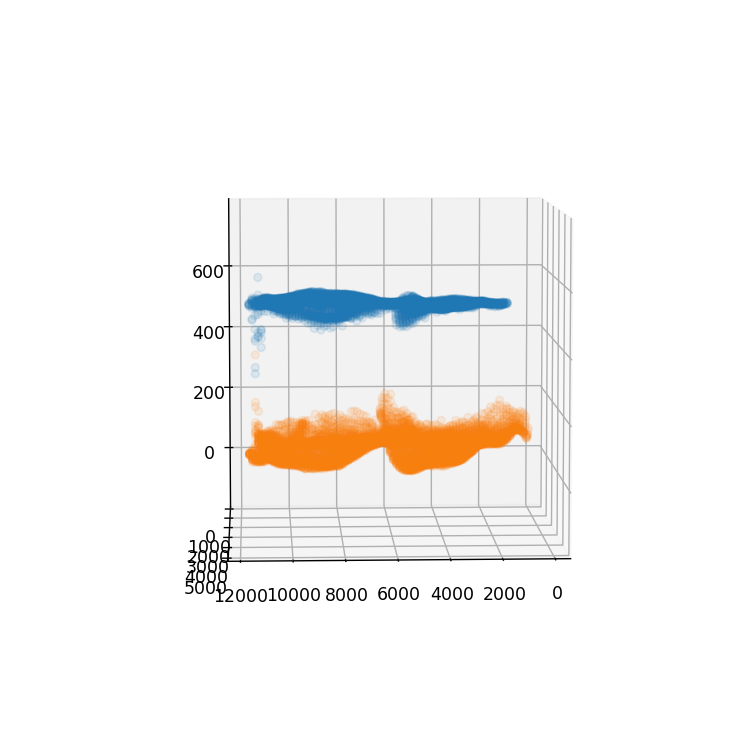

(-177.0, 799.0)

In [7]:
# Top slab
surf_dir = bdir(name_prefix+'_downsampled_thinsurface_bottom_polygon.zarr') # thin surface zarr
save_path = surf_dir[:-5]+'_endpts.npy'
surf_dir_2 = bdir(name_prefix+'_downsampled_thinsurface_top_polygon.zarr')
save_path_2 = surf_dir_2[:-5]+'_endpts.npy'
grid_size = (100,100) # how many points to sample on surface 
downsample_factor = (20,20,1)


####

surf_pts = sample_surface(surf_dir, grid_size, save_path=save_path)
surf_pts_2 = sample_surface(surf_dir_2, grid_size, save_path=save_path_2)

# Visualize 
#Plot these coordinates in real space 
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(surf_pts[:,0]*downsample_factor[0],surf_pts[:,1]*downsample_factor[1],
           surf_pts[:,2]*downsample_factor[2],antialiased=True, alpha=0.1)
ax.scatter(surf_pts_2[:,0]*downsample_factor[0],surf_pts_2[:,1]*downsample_factor[1],
           surf_pts_2[:,2]*downsample_factor[2],antialiased=True, alpha=0.1)
ax.set_zlim3d(np.minimum(surf_pts[:,2].min()-200, surf_pts_2[:,2].min()-200),
              np.maximum(surf_pts[:,2].max()+200, surf_pts_2[:,2].max()+200))


<IPython.core.display.Javascript object>


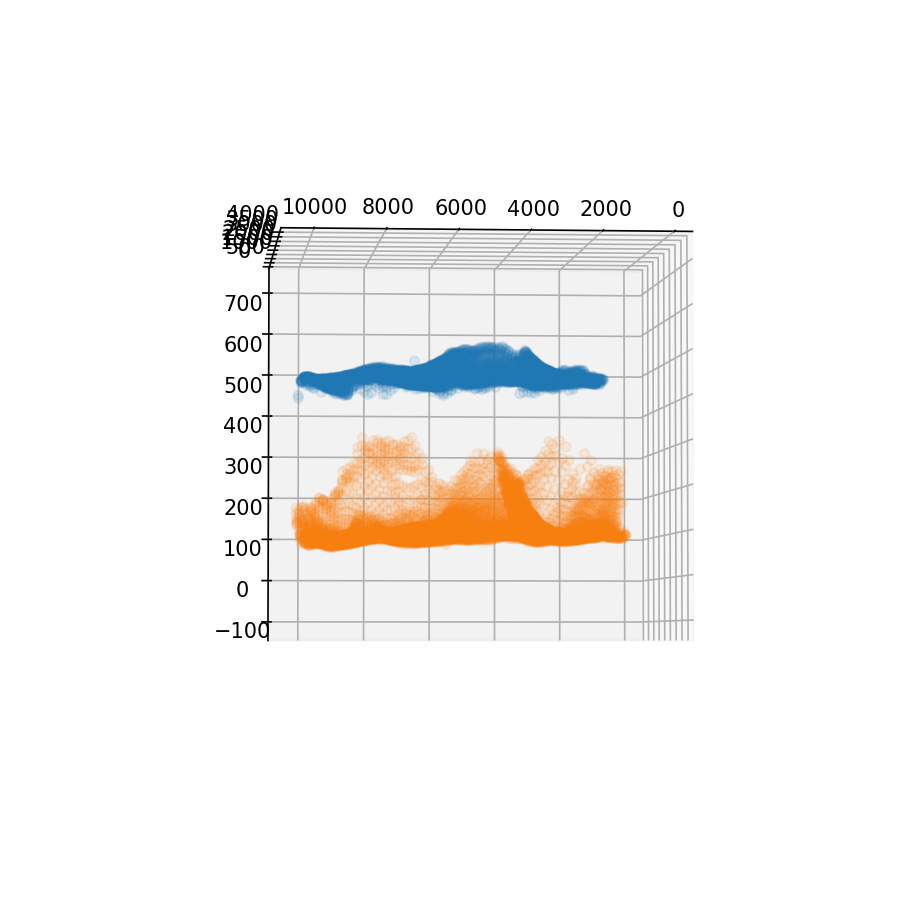

(-127.0, 742.0)

In [36]:
# Bottom slab
surf_dir = bdir(name_prefix2+'_downsampled_thinsurface_bottom_polygon.zarr')
save_path = surf_dir[:-5]+'_endpts.npy'
surf_dir_2 = bdir(name_prefix2+'_downsampled_thinsurface_top_polygon.zarr')
save_path_2 = surf_dir_2[:-5]+'_endpts.npy'
grid_size = (100,100) # how many points to sample on surface 
downsample_factor = (20,20,1)


####

surf_pts = sample_surface(surf_dir, grid_size, save_path=save_path)
surf_pts_2 = sample_surface(surf_dir_2, grid_size, save_path=save_path_2)

# Visualize 
#Plot these coordinates in real space 
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(surf_pts[:,0]*downsample_factor[0],surf_pts[:,1]*downsample_factor[1],
           surf_pts[:,2]*downsample_factor[2],antialiased=True, alpha=0.1)
ax.scatter(surf_pts_2[:,0]*downsample_factor[0],surf_pts_2[:,1]*downsample_factor[1],
           surf_pts_2[:,2]*downsample_factor[2],antialiased=True, alpha=0.1)
ax.set_zlim3d(np.minimum(surf_pts[:,2].min()-200, surf_pts_2[:,2].min()-200),
              np.maximum(surf_pts[:,2].max()+200, surf_pts_2[:,2].max()+200))


## Outlier removal 

0. Contour outlier removal <br>
1. Gradient outlier removal<br>
2. Statistical outlier removal<br>

[Return to top](#top)

<a id='outlier_surf'></a>

### Top slab, top surface

## Contour outlier removal

Use the manually selected contour (in non-downsampled resolution) to filter out points outside of it

In [6]:
# Filter out the points using the actual contour points 
contour_pts_path = bdir('manual_anchor_labels/fig2_20220315_ogframe_surf_top_top_concavehull.json')
json_name = 'top_concave_hull' # if contour_pts_path is json, then we need a channel name for the annotations
img_shape = [12000,5000]#,600]
mask_path = bdir('manual_anchor_labels/top_top_contour.tif') # concave hull mask write path

##################
border_pts = read_annotations_json(contour_pts_path, json_name)
img = Image.new('L', img_shape[:2], 0)
ImageDraw.Draw(img).polygon([tuple(border_pt.astype('int')) for border_pt in border_pts[:,:2]], outline=1, fill=1)
mask = np.array(img).T

io.writeData(mask_path,mask)

'/mnt/beegfs/webster/fig2_coronal/manual_anchor_labels/top_top_contour.tif'

In [7]:
# Now mask the point cloud 
eps_path = bdir(name_prefix+'_downsampled_thinsurface_top_polygon_endpts.npy')
eps_save_path = eps_path[:-4]+'_contourfiltered.npy'
upsample_factor = 20
mask_path = bdir('manual_anchor_labels/top_top_contour.tif')
img_shape = [12000,5000]

##################
eps_filtered = mask_point_cloud(eps_path, mask_path, img_shape, eps_save_path=eps_save_path, resample_factor=upsample_factor)

TiffFile: the 'fastij' argument is ignored


In [9]:
print(np.load(eps_path).shape, eps_filtered.shape)

(5925, 3) (5896, 3)


5925it [00:01, 3838.01it/s]


<IPython.core.display.Javascript object>


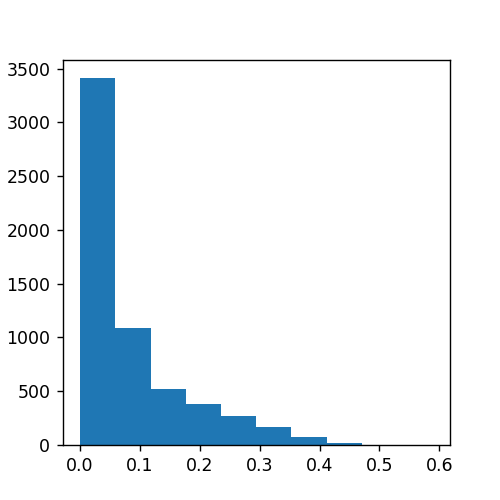

<IPython.core.display.Javascript object>


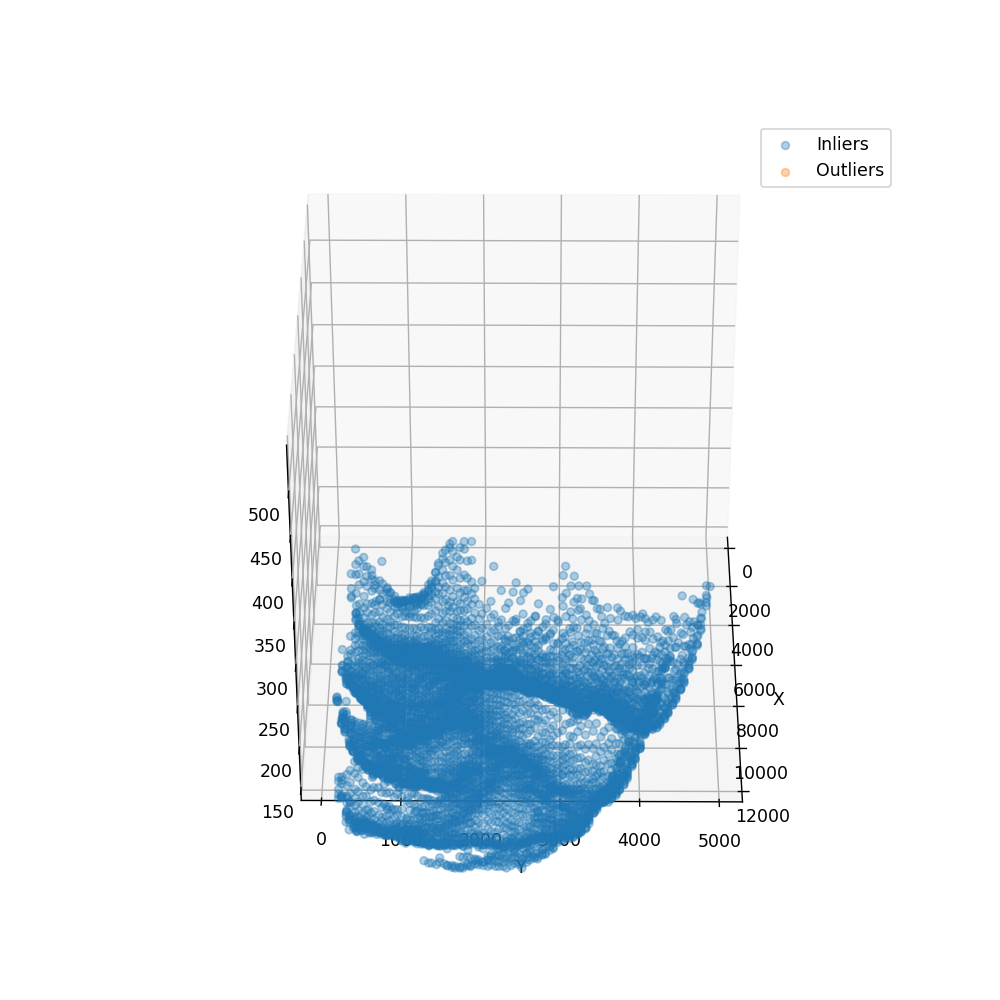

In [8]:
# Gradient outlier removal 
do_grad_removal = True 
eps_path = bdir(name_prefix+'_downsampled_thinsurface_top_polygon_endpts.npy')
eps_save_path = None
num_nns = 20 # number of nearest neighbors to use for gradient estimation
threshold = 2.0 # threshold for gradient magnitude at which to divide positives and negatives
plot= True # whether or not to plot the histogram
downsample_factor = (20,20,1)

#############################
eps_new = np.load(eps_path)
eps_new[:,0] *= downsample_factor[0]; eps_new[:,1] *= downsample_factor[1]; eps_new[:,2] *= downsample_factor[2]
if do_grad_removal:
    eps_new_grad = gradient_remove_outliers(eps_new, num_nns, threshold=threshold, plot=plot)
else:
    eps_new_grad = eps_new
if eps_save_path is not None:
    np.save(eps_save_path, eps_new_grad)

Std. dev: 10.147198499214982
Mean: 9.010582278481012
Number of inliers: 5832
Number of outliers: 93


<IPython.core.display.Javascript object>


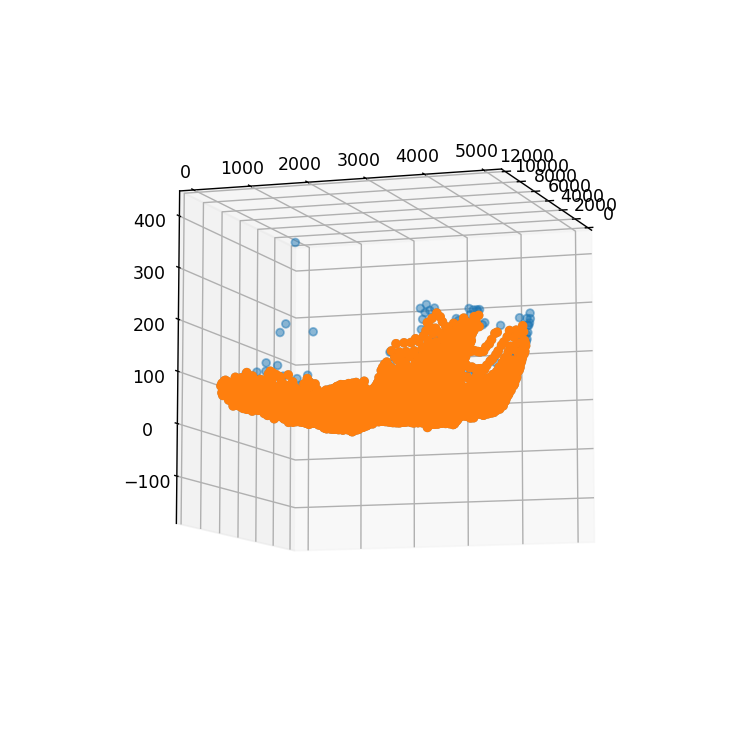

In [11]:
# Statistical outlier removal
do_outlier_removal = True
nn = 20
std_dev_threshold = 3.0
nn_mode = 'lateral'
dist_mode = 'z'
save_path = bdir(name_prefix+'_downsampled_thinsurface_top_polygon_endpts_outlier.npy')

if do_outlier_removal:
    newpts = remove_statistical_outliers(eps_new_grad, nn, std_dev_threshold, nn_mode=nn_mode, dist_mode=dist_mode)
    print("Number of outliers:",eps_new_grad.shape[0]-newpts.shape[0])
    
    #Visualize  
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(eps_new_grad[:,0],eps_new_grad[:,1],eps_new_grad[:,2],antialiased=True, alpha=0.5)
    ax.scatter(newpts[:,0],newpts[:,1],newpts[:,2],antialiased=True, alpha=1.0)
    ax.set_zlim3d(newpts[:,2].min()-200,newpts[:,2].max()+200)
    
    if save_path is not None:
        np.save(save_path, newpts)
        
   

### Top slab, bottom surface

## Contour outlier removal

Use the manually selected contour (in non-downsampled resolution) to filter out points outside of it

In [12]:
# Filter out the points using the actual contour points 
contour_pts_path = bdir('manual_anchor_labels/fig2_20220315_ogframe_surf_top_top_concavehull.json')
json_name = 'top_bottom_concavehull' # if contour_pts_path is json, then we need a channel name for the annotations
img_shape = [12000,5000]#,600]
mask_path = bdir('manual_anchor_labels/top_bottom_contour.tif') # concave hull mask write path

##################
border_pts = read_annotations_json(contour_pts_path, json_name)
img = Image.new('L', img_shape[:2], 0)
ImageDraw.Draw(img).polygon([tuple(border_pt.astype('int')) for border_pt in border_pts[:,:2]], outline=1, fill=1)
mask = np.array(img).T

io.writeData(mask_path,mask)

'/mnt/beegfs/webster/fig2_coronal/manual_anchor_labels/top_bottom_contour.tif'

In [13]:
# Now mask the point cloud 
eps_path = bdir(name_prefix+'_downsampled_thinsurface_bottom_polygon_endpts.npy')
eps_save_path = eps_path[:-4]+'_contourfiltered.npy'
upsample_factor = 20
mask_path = bdir('manual_anchor_labels/top_bottom_contour.tif')
img_shape = [12000,5000]

##################
eps_filtered = mask_point_cloud(eps_path, mask_path, img_shape, eps_save_path=eps_save_path, resample_factor=upsample_factor)

TiffFile: the 'fastij' argument is ignored


In [14]:
print(np.load(eps_path).shape, eps_filtered.shape)

(4500, 3) (4472, 3)


4500it [00:01, 3652.18it/s]


<IPython.core.display.Javascript object>


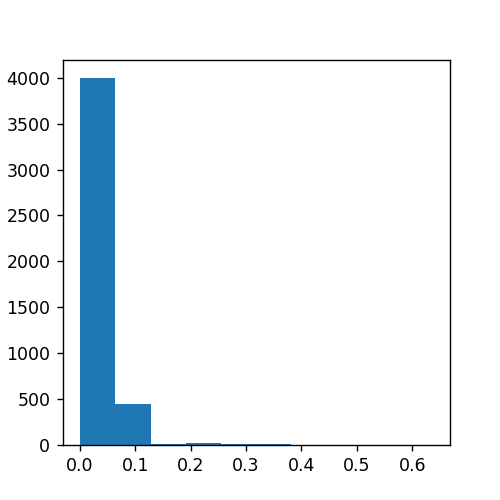

<IPython.core.display.Javascript object>


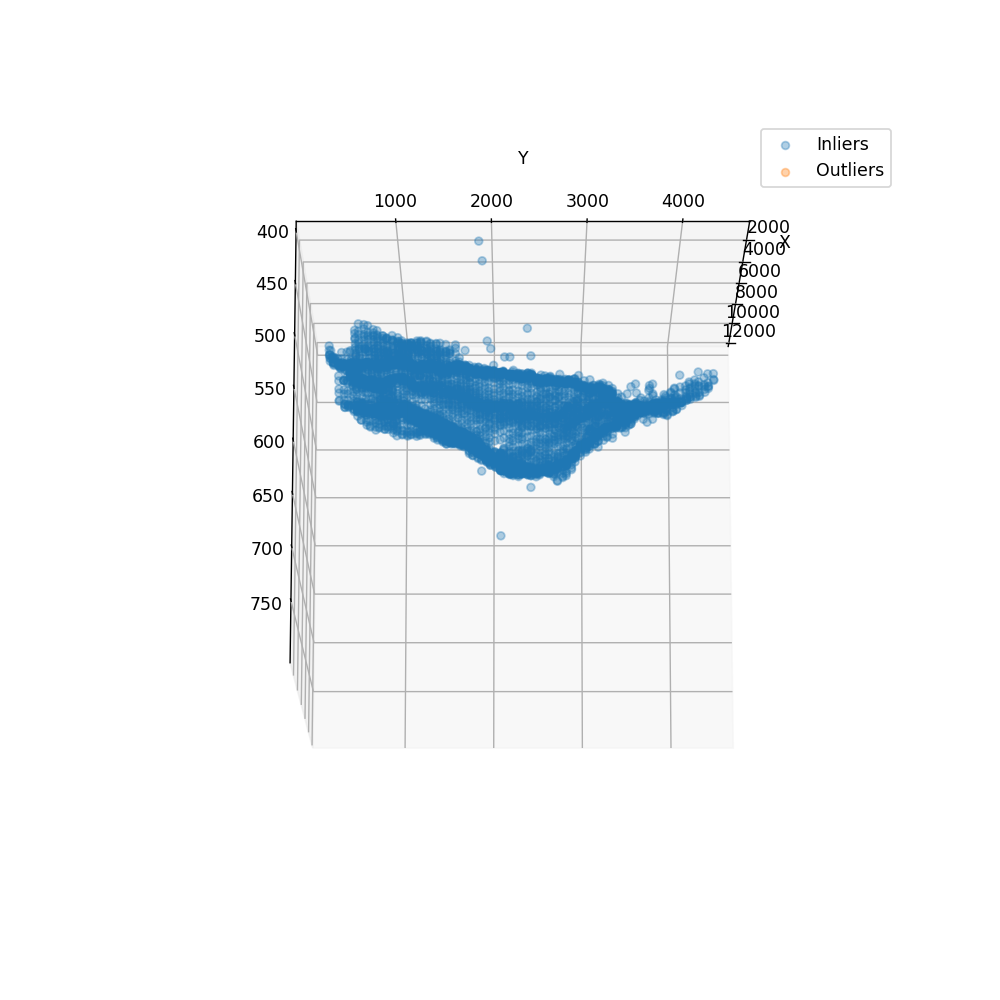

In [15]:
# Gradient outlier removal 
do_grad_removal = True 
eps_path = bdir(name_prefix+'_downsampled_thinsurface_bottom_polygon_endpts.npy')
eps_save_path = None
num_nns = 20 # number of nearest neighbors to use for gradient estimation
threshold = 1.0 # threshold for gradient magnitude at which to divide positives and negatives
plot= True # whether or not to plot the histogram
downsample_factor = (20,20,1)

#############################
eps_new = np.load(eps_path)
eps_new[:,0] *= downsample_factor[0]; eps_new[:,1] *= downsample_factor[1]; eps_new[:,2] *= downsample_factor[2]
if do_grad_removal:
    eps_new_grad = gradient_remove_outliers(eps_new, num_nns, threshold=threshold, plot=plot)
else:
    eps_new_grad = eps_new
if eps_save_path is not None:
    np.save(eps_save_path, eps_new_grad)

Std. dev: 7.546102608648183
Mean: 4.451444444444444
Number of inliers: 4444
Number of outliers: 56


<IPython.core.display.Javascript object>


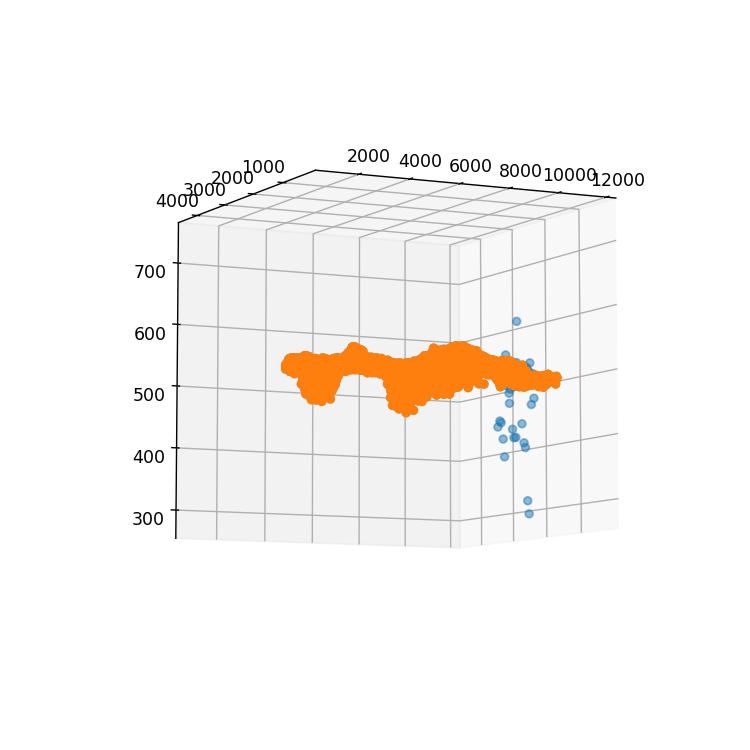

In [17]:
# Statistical outlier removal
do_outlier_removal = True
nn = 20
std_dev_threshold = 3.0
nn_mode = 'lateral'
dist_mode = 'z'
save_path = bdir(name_prefix+'_downsampled_thinsurface_bottom_polygon_endpts_outlier.npy') 

if do_outlier_removal:
    newpts = remove_statistical_outliers(eps_new_grad, nn, std_dev_threshold, nn_mode=nn_mode, dist_mode=dist_mode)
    print("Number of outliers:",eps_new_grad.shape[0]-newpts.shape[0])
    
    #Visualize  
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(eps_new_grad[:,0],eps_new_grad[:,1],eps_new_grad[:,2],antialiased=True, alpha=0.5)
    ax.scatter(newpts[:,0],newpts[:,1],newpts[:,2],antialiased=True, alpha=1)
    ax.set_zlim3d(newpts[:,2].min()-200,newpts[:,2].max()+200)
    
    if save_path is not None:
        np.save(save_path, newpts)

### Bottom slab, top surface

## Contour outlier removal

Use the manually selected contour (in non-downsampled resolution) to filter out points outside of it

In [98]:
# Filter out the points using the actual contour points 
contour_pts_path = bdir('manual_anchor_labels/bot_top_concavehull_pts.json')
json_name = 'bot_top_concavehull' # if contour_pts_path is json, then we need a channel name for the annotations
img_shape = [10400,4200]#,600]

##################
border_pts = read_annotations_json(contour_pts_path, json_name)
img = Image.new('L', img_shape[:2], 0)
ImageDraw.Draw(img).polygon([tuple(border_pt.astype('int')) for border_pt in border_pts[:,:2]], outline=1, fill=1)
mask = np.array(img).T

io.writeData(bdir('manual_anchor_labels/bot_top_contour.tif'),mask)

'/mnt/beegfs/webster/fig2_coronal/manual_anchor_labels/bot_top_contour.tif'

In [3]:
# Now mask the point cloud 
eps_path = bdir(name_prefix2+'_downsampled_thinsurface_top_polygon_endpts.npy')
eps_save_path = eps_path[:-4]+'_contourfiltered.npy'
upsample_factor = 20
mask_path = bdir('manual_anchor_labels/bot_top_contour.tif')
img_shape = [10400,4200]

##################
eps_filtered = mask_point_cloud(eps_path, mask_path, img_shape, eps_save_path=eps_save_path, resample_factor=upsample_factor)

TiffFile: the 'fastij' argument is ignored


379it [00:00, 3785.88it/s]

(6013, 3)


6013it [00:01, 4027.69it/s]


<IPython.core.display.Javascript object>


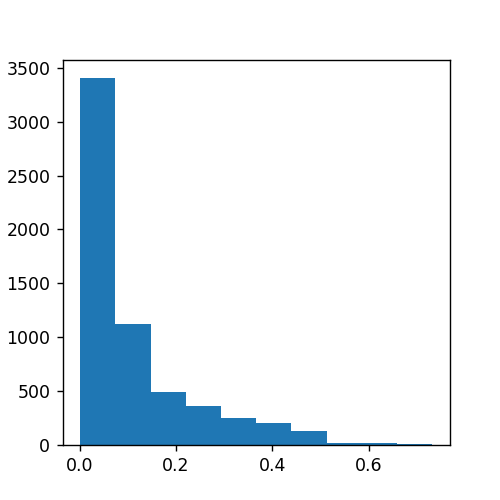

<IPython.core.display.Javascript object>


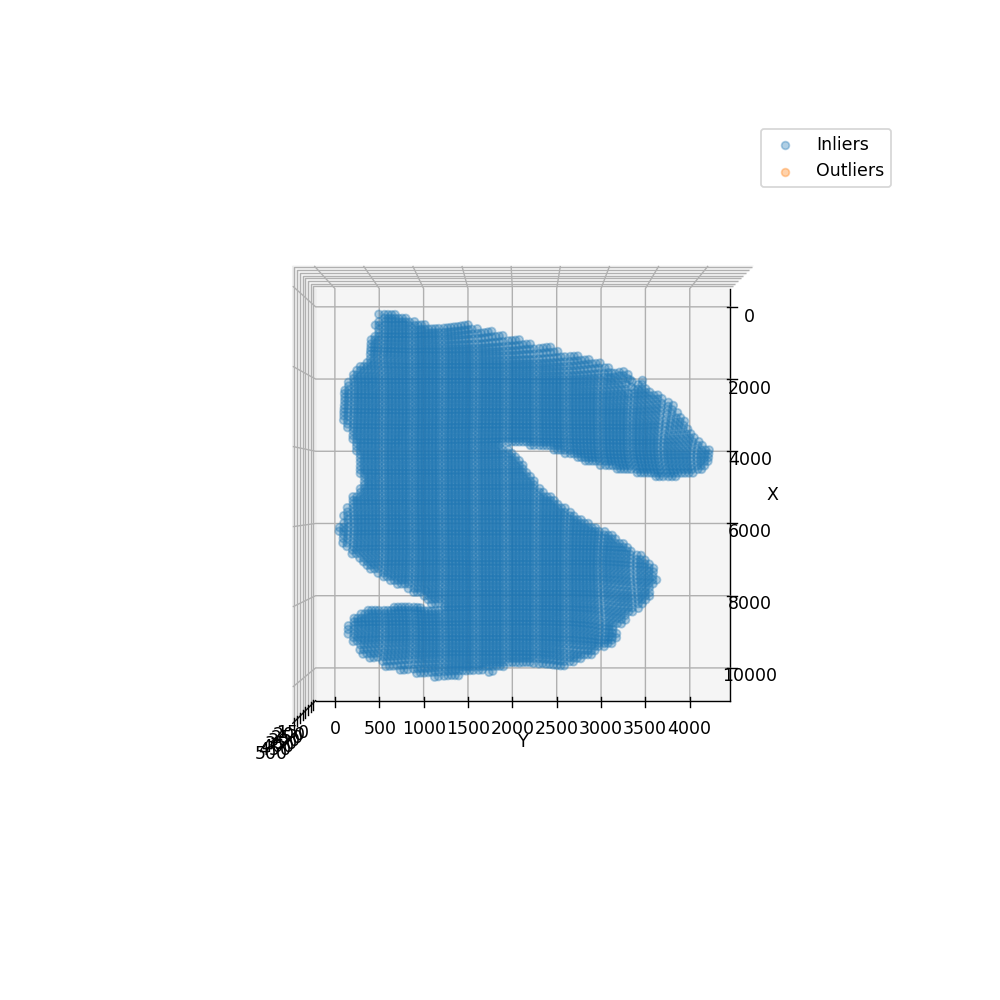

In [3]:
# Gradient outlier removal 
do_grad_removal = True 
eps_path = bdir(name_prefix2+'_downsampled_thinsurface_top_polygon_endpts_contourfiltered.npy')
eps_save_path = None
num_nns = 20 # number of nearest neighbors to use for gradient estimation
threshold = 2.0 # threshold for gradient magnitude at which to divide positives and negatives
plot= True # whether or not to plot the histogram
downsample_factor = (20,20,1)

#############################
eps_new = np.load(eps_path)
print(eps_new.shape)
eps_new[:,0] *= downsample_factor[0]; eps_new[:,1] *= downsample_factor[1]; eps_new[:,2] *= downsample_factor[2]
if do_grad_removal:
    eps_new_grad = gradient_remove_outliers(eps_new, num_nns, threshold=threshold, plot=plot)
else:
    eps_new_grad = eps_new
if eps_save_path is not None:
    np.save(eps_save_path, eps_new_grad)

Std. dev: 10.183172435593036
Mean: 9.355180442374854
Number of inliers: 5978


<IPython.core.display.Javascript object>


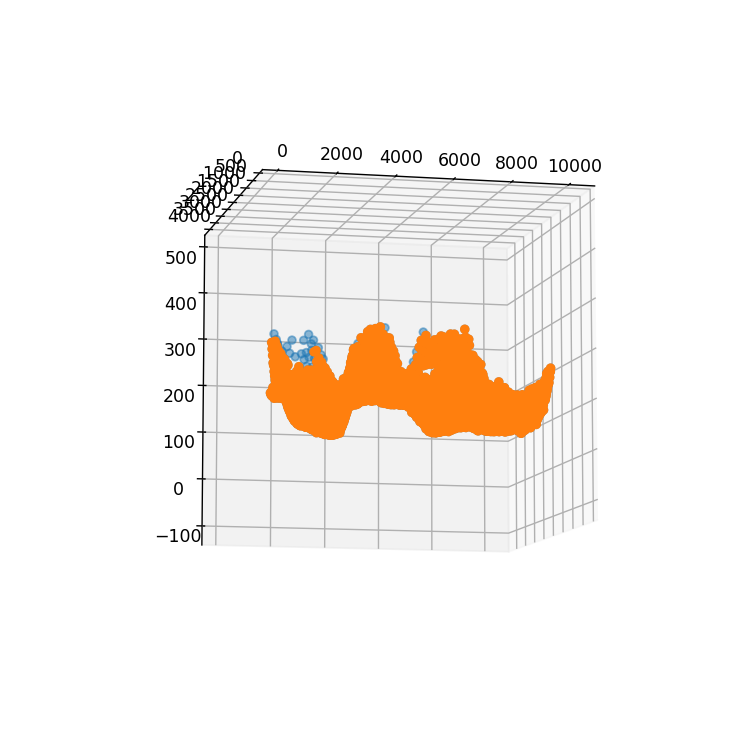

Number of outliers: 35


In [4]:
# Statistical outlier removal
do_outlier_removal = True
nn = 20
std_dev_threshold = 4.0
nn_mode = 'lateral'
dist_mode = 'z'
save_path = bdir(name_prefix2+'_downsampled_thinsurface_top_polygon_endpts_outlier.npy')

if do_outlier_removal:
    newpts = remove_statistical_outliers(eps_new_grad, nn, std_dev_threshold, nn_mode=nn_mode, dist_mode=dist_mode)

    #Visualize  
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(eps_new_grad[:,0],eps_new_grad[:,1],eps_new_grad[:,2],antialiased=True, alpha=0.5)
    ax.scatter(newpts[:,0],newpts[:,1],newpts[:,2],antialiased=True, alpha=1)
    ax.set_zlim3d(newpts[:,2].min()-200,newpts[:,2].max()+200)
    
    if save_path is not None:
        np.save(save_path, newpts)
    
    print("Number of outliers:",eps_new_grad.shape[0]-newpts.shape[0])

### Bottom slab, bottom surface

In [7]:
# Filter out the points using the actual contour points 
contour_pts_path = bdir('manual_anchor_labels/bot_top_concavehull_pts.json')
json_name = 'bot_bottom_concavehull' # if contour_pts_path is json, then we need a channel name for the annotations
img_shape = [10400,4200]#,600]

##################
border_pts = read_annotations_json(contour_pts_path, json_name)
img = Image.new('L', img_shape[:2], 0)
ImageDraw.Draw(img).polygon([tuple(border_pt.astype('int')) for border_pt in border_pts[:,:2]], outline=1, fill=1)
mask = np.array(img).T

io.writeData(bdir('manual_anchor_labels/bot_bottom_contour.tif'),mask)

'/mnt/beegfs/webster/fig2_coronal/manual_anchor_labels/bot_bottom_contour.tif'

In [8]:
# Now mask the point cloud 
eps_path = bdir(name_prefix2+'_downsampled_thinsurface_bottom_polygon_endpts.npy')
eps_save_path = eps_path[:-4]+'_contourfiltered.npy'
upsample_factor = 20
mask_path = bdir('manual_anchor_labels/bot_bottom_contour.tif')
img_shape = [10400,4200]

##################
eps_filtered = mask_point_cloud(eps_path, mask_path, img_shape, eps_save_path=eps_save_path, resample_factor=upsample_factor)

TiffFile: the 'fastij' argument is ignored


4224it [00:01, 3946.71it/s]


<IPython.core.display.Javascript object>


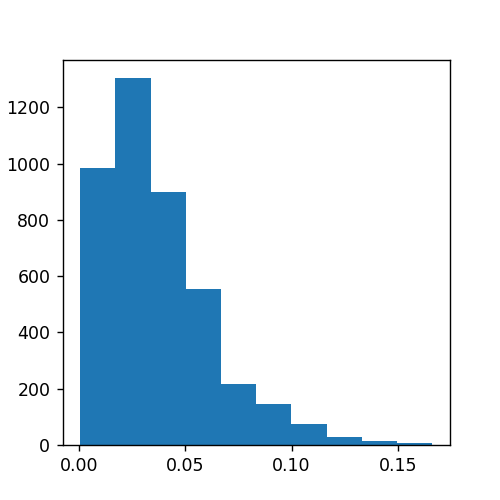

<IPython.core.display.Javascript object>


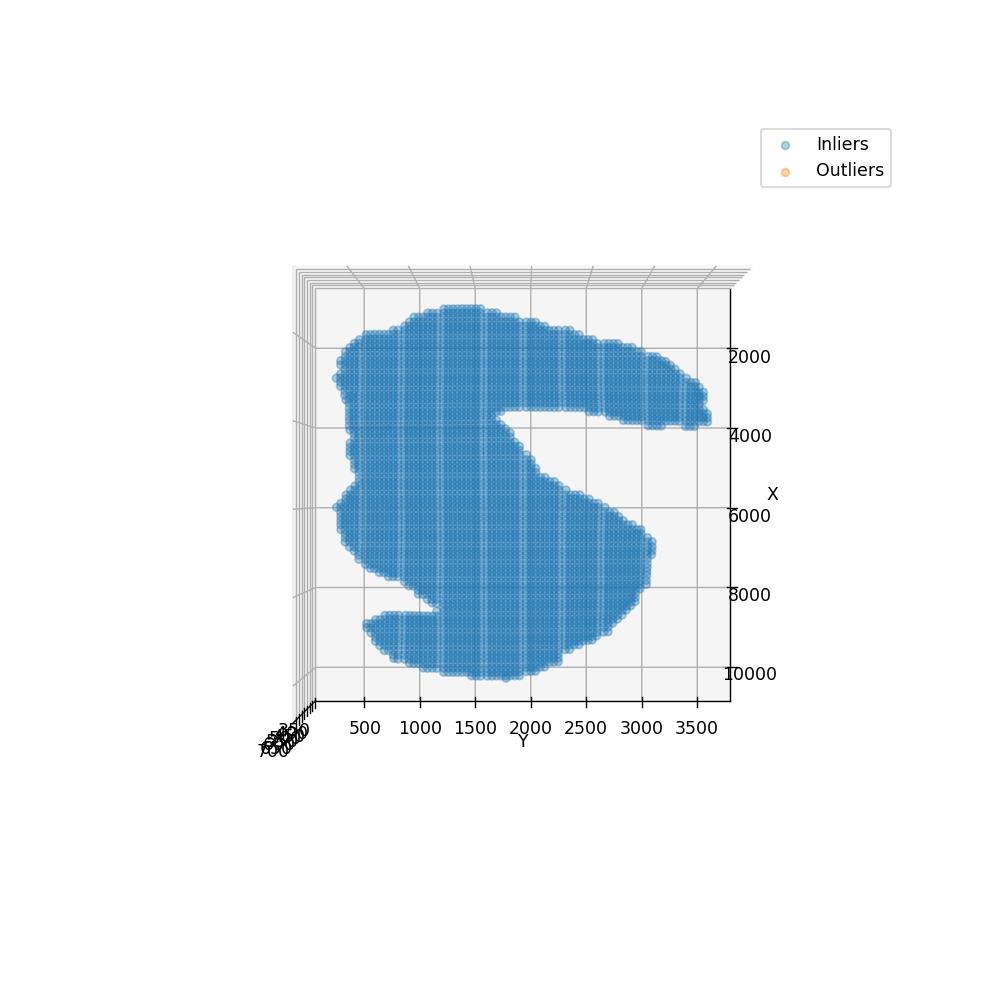

In [5]:
# Gradient outlier removal 
do_grad_removal = True 
eps_path = bdir(name_prefix2+'_downsampled_thinsurface_bottom_polygon_endpts_contourfiltered.npy')
eps_save_path = None
num_nns = 20 # number of nearest neighbors to use for gradient estimation
threshold = 2.0 # threshold for gradient magnitude at which to divide positives and negatives
plot= True # whether or not to plot the histogram
downsample_factor = (20,20,1)

#############################
eps_new = np.load(eps_path)
eps_new[:,0] *= downsample_factor[0]; eps_new[:,1] *= downsample_factor[1]; eps_new[:,2] *= downsample_factor[2]
if do_grad_removal:
    eps_new_grad = gradient_remove_outliers(eps_new, num_nns, threshold=threshold, plot=plot)
else:
    eps_new_grad = eps_new
if eps_save_path is not None:
    np.save(eps_save_path, eps_new_grad)

Std. dev: 2.484629534360157
Mean: 3.5222774621212123
Number of inliers: 4179
Number of outliers: 45


<IPython.core.display.Javascript object>


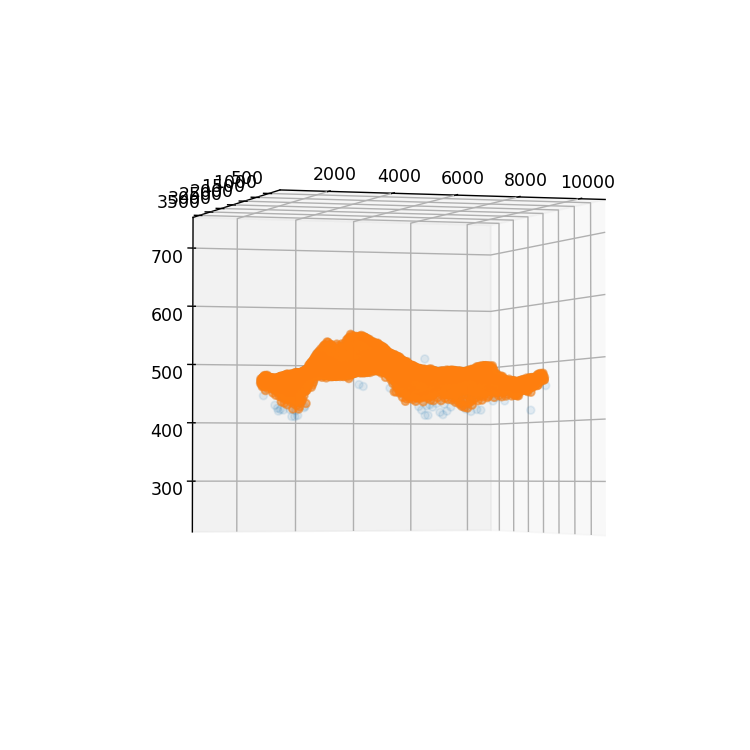

In [6]:
# Statistical outlier removal
do_outlier_removal = True
nn = 20
std_dev_threshold = 3.5
nn_mode = 'lateral'
dist_mode = 'z'
save_path = bdir(name_prefix2+'_downsampled_thinsurface_bottom_polygon_endpts_outlier.npy') 

if do_outlier_removal:
    newpts = remove_statistical_outliers(eps_new_grad, nn, std_dev_threshold, nn_mode=nn_mode, dist_mode=dist_mode)
    print("Number of outliers:",eps_new_grad.shape[0]-newpts.shape[0])
    
    #Visualize  
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(eps_new_grad[:,0],eps_new_grad[:,1],eps_new_grad[:,2],antialiased=True, alpha=0.1)
    ax.scatter(newpts[:,0],newpts[:,1],newpts[:,2],antialiased=True, alpha=0.5)
    ax.set_zlim3d(newpts[:,2].min()-200,newpts[:,2].max()+200)
    
    if save_path is not None:
        np.save(save_path, newpts)
    
    

## UV map surfaces

[Return to top](#top)

<a id='uvmap'></a>

<IPython.core.display.Javascript object>


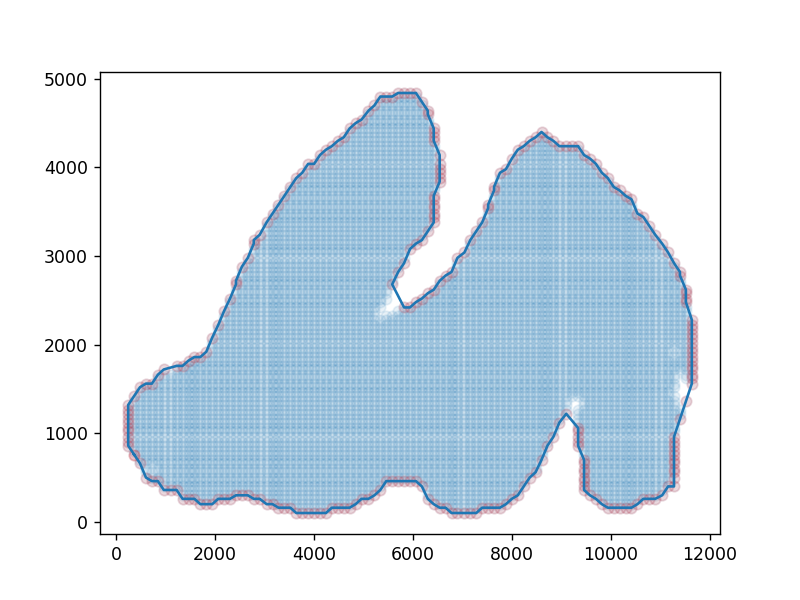

11394it [00:00, 17019.90it/s]


<IPython.core.display.Javascript object>


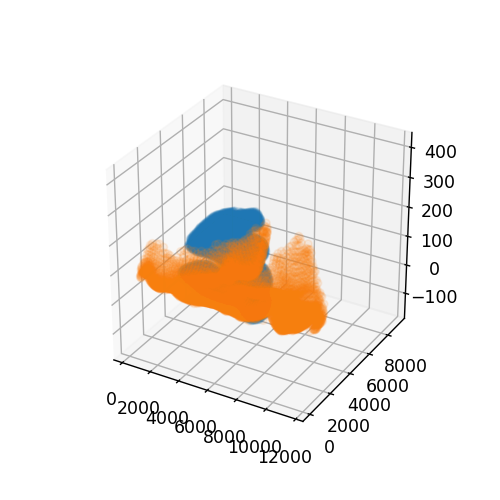

<IPython.core.display.Javascript object>


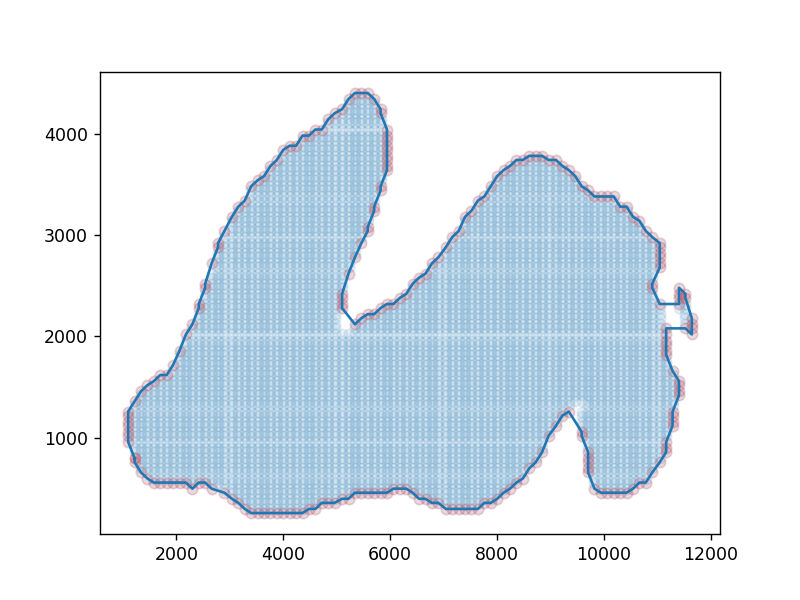

8642it [00:00, 18319.75it/s]


<IPython.core.display.Javascript object>


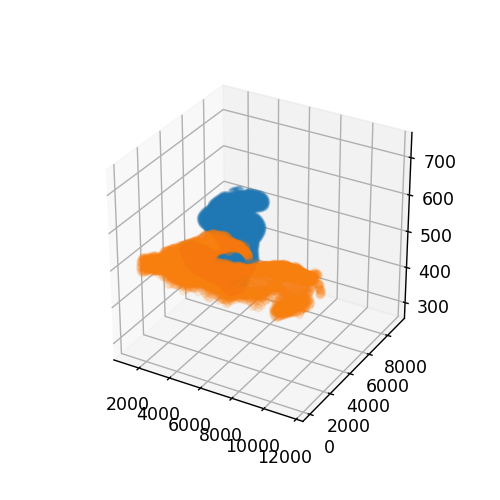

In [33]:
# Top slab

# Top surface 
surf_eps_path = bdir(name_prefix+'_downsampled_thinsurface_top_polygon_endpts_outlier.npy')
surf_eps_uv_path = bdir(name_prefix+'_downsampled_thinsurface_top_polygon_endpts_outlier_uv.npy')
zcoord = None # the z coordinate at which we want the UV map to reside. If none, then will self calculate

# Bottom surface

surf_eps_path2 = bdir(name_prefix+'_downsampled_thinsurface_bottom_polygon_endpts_outlier.npy')
surf_eps_uv_path2 = bdir(name_prefix+'_downsampled_thinsurface_bottom_polygon_endpts_outlier_uv.npy')
zcoord2 = None 

plot = True
alpha = 0.0055 # Parameter for producing a concave mesh. Higher alpha --> more concave

####################################
eps_uv = flatten(surf_eps_path, surf_eps_uv_path, zcoord=zcoord, plot=plot, alpha=alpha)
eps_uv2 = flatten(surf_eps_path2, surf_eps_uv_path2, zcoord=zcoord2, plot=plot, alpha=alpha)

<IPython.core.display.Javascript object>


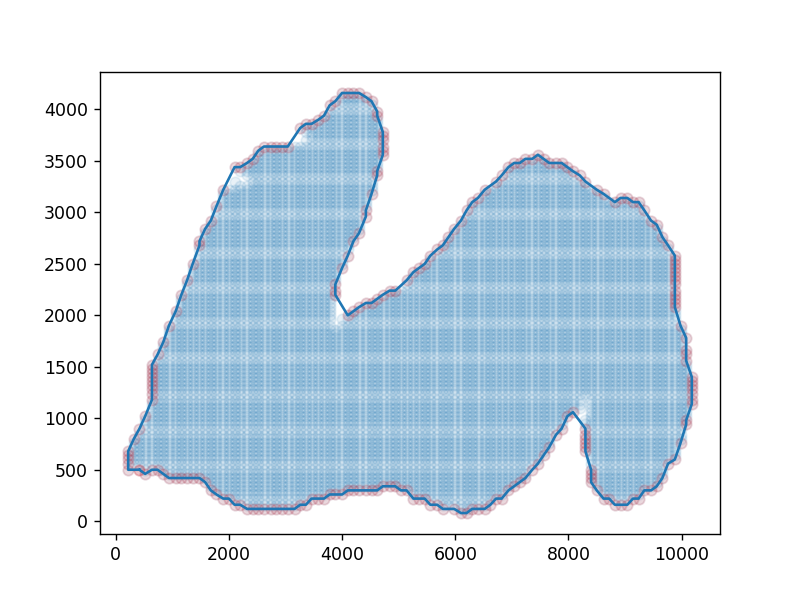

11705it [00:00, 16604.00it/s]


<IPython.core.display.Javascript object>


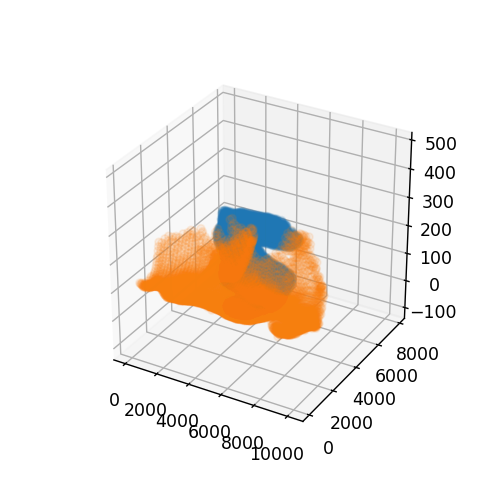

<IPython.core.display.Javascript object>


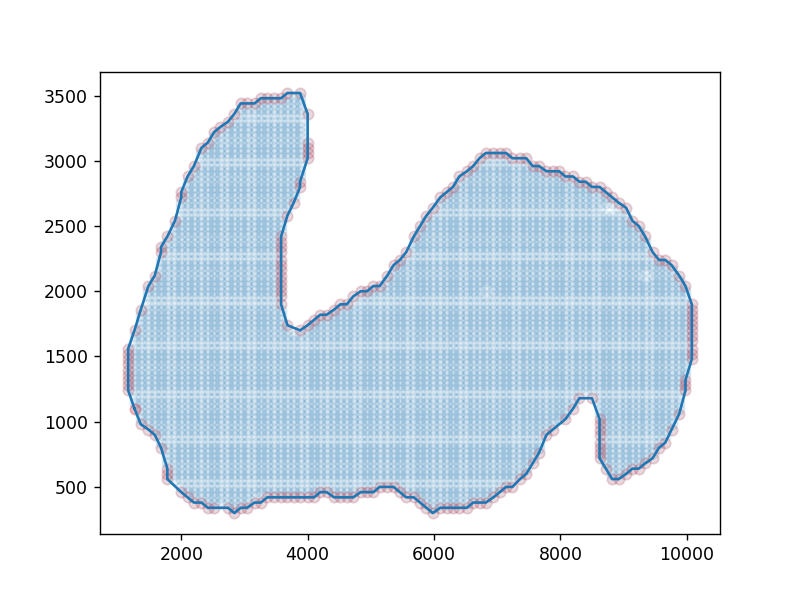

8136it [00:00, 19036.97it/s]


<IPython.core.display.Javascript object>


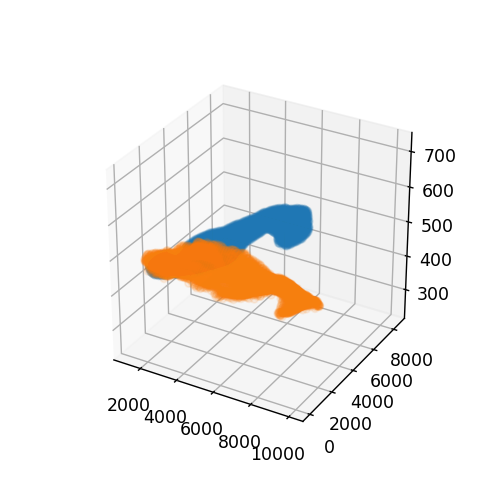

In [34]:
# Bottom slab

# Top surface 
surf_eps_path = bdir(name_prefix2+'_downsampled_thinsurface_top_polygon_endpts_outlier.npy')
surf_eps_uv_path = bdir(name_prefix2+'_downsampled_thinsurface_top_polygon_endpts_outlier_uv.npy')
zcoord = None # the z coordinate at which we want the UV map to reside. If none, then will self calculate

# Bottom surface

surf_eps_path2 = bdir(name_prefix2+'_downsampled_thinsurface_bottom_polygon_endpts_outlier.npy')
surf_eps_uv_path2 = bdir(name_prefix2+'_downsampled_thinsurface_bottom_polygon_endpts_outlier_uv.npy')
zcoord2 = None 

plot = True
alpha = 0.0055 # Parameter for producing a concave mesh. Higher alpha --> more concave. Around 0.005 is usually good 

####################################
eps_uv = flatten(surf_eps_path, surf_eps_uv_path, zcoord=zcoord, plot=plot, alpha=alpha)
eps_uv2 = flatten(surf_eps_path2, surf_eps_uv_path2, zcoord=zcoord2, plot=plot, alpha=alpha)

## Align the UV maps rigidly to image  

[Return to top](#top)

<a id='uvuvalign'></a>

### Top slab

In [35]:
# old flattened and non-flattened paths
top_eps_path = bdir(name_prefix+'_downsampled_thinsurface_top_polygon_endpts_outlier.npy')
top_eps_uv_path = bdir(name_prefix+'_downsampled_thinsurface_top_polygon_endpts_outlier_uv.npy')
bot_eps_path = bdir(name_prefix+'_downsampled_thinsurface_bottom_polygon_endpts_outlier.npy')
bot_eps_uv_path = bdir(name_prefix+'_downsampled_thinsurface_bottom_polygon_endpts_outlier_uv.npy')

# new flattened and non-flattened paths, after filtering, UV-UV aligning, and surface-UV aligning 
top_eps_path2 = bdir(name_prefix+'_downsampled_thinsurface_top_polygon_endpts_outlier_new.npy')
top_eps_uv_path2 = bdir(name_prefix+'_downsampled_thinsurface_top_polygon_endpts_outlier_uv_new.npy')
bot_eps_path2 = bdir(name_prefix+'_downsampled_thinsurface_bottom_polygon_endpts_outlier_new.npy')
bot_eps_uv_path2 = bdir(name_prefix+'_downsampled_thinsurface_bottom_polygon_endpts_outlier_uv_new.npy')


Mean thickness: 443.0392832647462
Mean thickness: 454.77092709270926
New mean thickness: 443.0392832647462


<IPython.core.display.Javascript object>


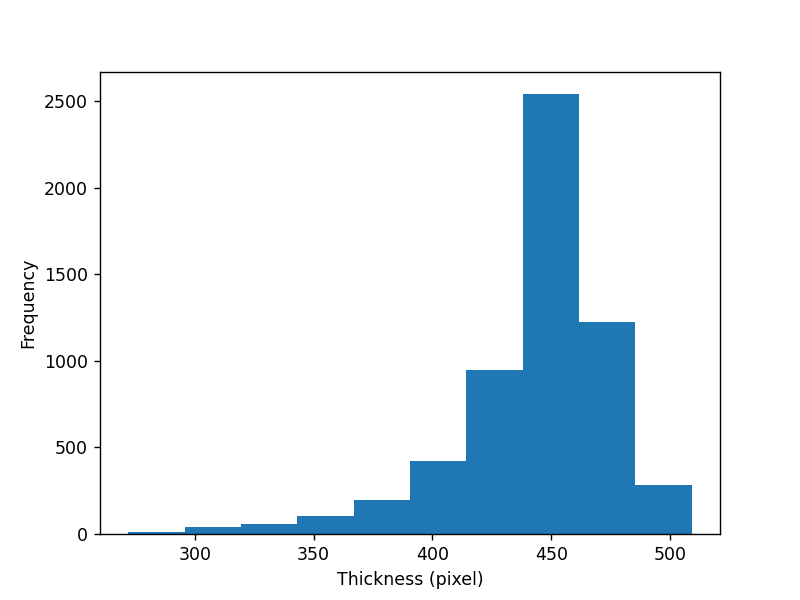

<IPython.core.display.Javascript object>


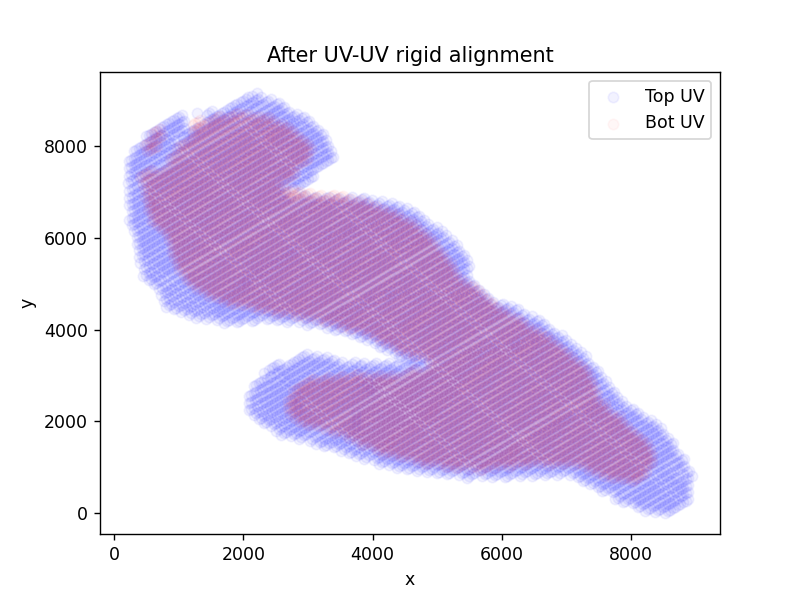

<IPython.core.display.Javascript object>


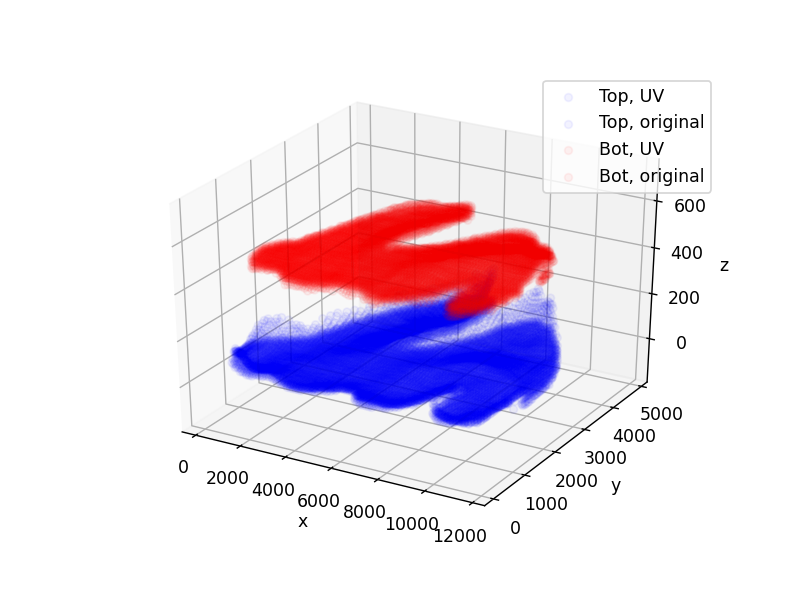

Number of top surface points:5832
Number of bottom surface points:4444


In [36]:
# Params 
thickness_filter = False
nns = 10
n_std = 2 # num std. devs away from mean thickness to remove
plot = True 


#############
bot_eps = np.load(bot_eps_path)
bot_eps_uv = np.load(bot_eps_uv_path)
top_eps = np.load(top_eps_path)
top_eps_uv = np.load(top_eps_uv_path)

top_eps_flat, top_eps_uv, bot_eps_flat, bot_eps_uv = align_uv_maps(top_eps, top_eps_uv, bot_eps, bot_eps_uv,
                                                                   thickness_filter=thickness_filter, nns=nns, n_std=n_std, plot=plot)

np.save(bot_eps_path2, bot_eps_flat)
np.save(bot_eps_uv_path2, bot_eps_uv)
np.save(top_eps_path2, top_eps_flat)
np.save(top_eps_uv_path2, top_eps_uv)

print("Number of top surface points:%d"%top_eps_flat.shape[0])
print("Number of bottom surface points:%d"%bot_eps_flat.shape[0])

### Bottom slab

In [37]:
# old flattened and non-flattened paths
top_eps_path = bdir(name_prefix2+'_downsampled_thinsurface_top_polygon_endpts_outlier.npy')
top_eps_uv_path = bdir(name_prefix2+'_downsampled_thinsurface_top_polygon_endpts_outlier_uv.npy')
bot_eps_path = bdir(name_prefix2+'_downsampled_thinsurface_bottom_polygon_endpts_outlier.npy')
bot_eps_uv_path = bdir(name_prefix2+'_downsampled_thinsurface_bottom_polygon_endpts_outlier_uv.npy')

# new flattened and non-flattened paths, after filtering, UV-UV aligning, and surface-UV aligning 
top_eps_path2 = bdir(name_prefix2+'_downsampled_thinsurface_top_polygon_endpts_outlier_new.npy')
top_eps_uv_path2 = bdir(name_prefix2+'_downsampled_thinsurface_top_polygon_endpts_outlier_uv_new.npy')
bot_eps_path2 = bdir(name_prefix2+'_downsampled_thinsurface_bottom_polygon_endpts_outlier_new.npy')
bot_eps_uv_path2 = bdir(name_prefix2+'_downsampled_thinsurface_bottom_polygon_endpts_outlier_uv_new.npy')


Mean thickness: 351.82974238875875
Mean thickness: 370.39533381191677
New mean thickness: 351.82974238875875


<IPython.core.display.Javascript object>


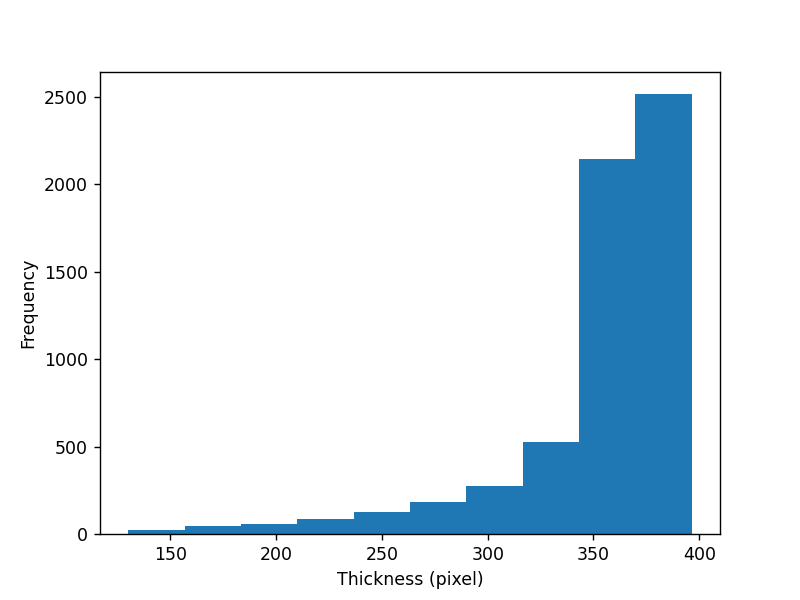

<IPython.core.display.Javascript object>


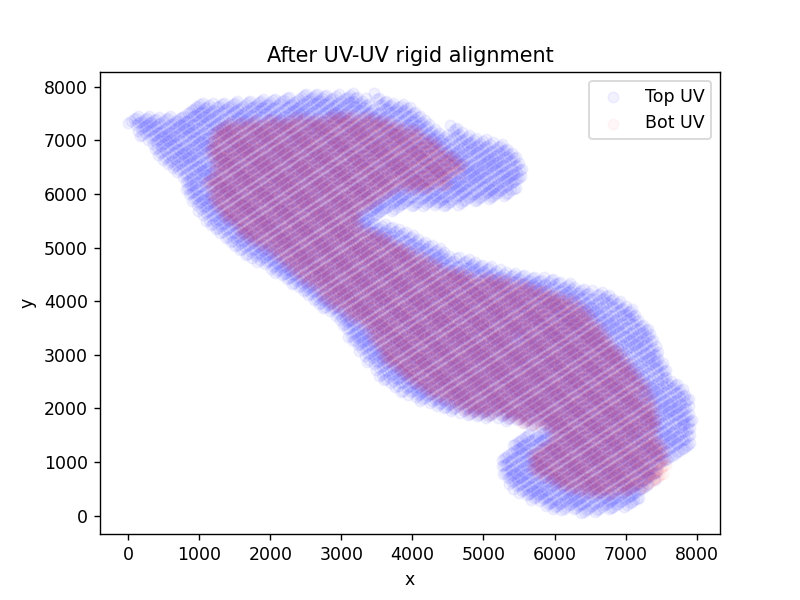

<IPython.core.display.Javascript object>


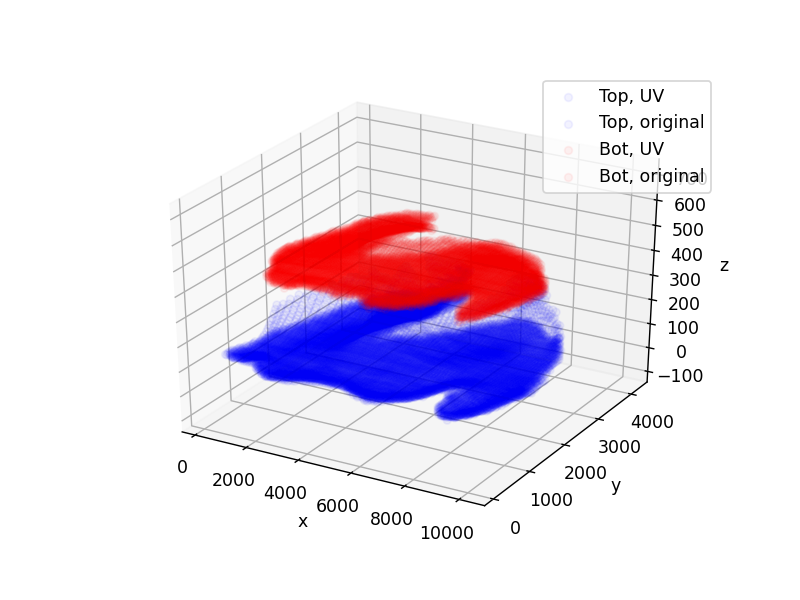

Number of top surface points:5978
Number of bottom surface points:4179


In [38]:
# Params 
thickness_filter = False
nns = 10
n_std = 2 # num std. devs away from mean thickness to remove
plot = True 


#############
bot_eps = np.load(bot_eps_path)
bot_eps_uv = np.load(bot_eps_uv_path)
top_eps = np.load(top_eps_path)
top_eps_uv = np.load(top_eps_uv_path)

top_eps_flat, top_eps_uv, bot_eps_flat, bot_eps_uv = align_uv_maps(top_eps, top_eps_uv, bot_eps, bot_eps_uv,
                                                                   thickness_filter=thickness_filter, nns=nns, n_std=n_std, plot=plot)

np.save(bot_eps_path2, bot_eps_flat)
np.save(bot_eps_uv_path2, bot_eps_uv)
np.save(top_eps_path2, top_eps_flat)
np.save(top_eps_uv_path2, top_eps_uv)

print("Number of top surface points:%d"%top_eps_flat.shape[0])
print("Number of bottom surface points:%d"%bot_eps_flat.shape[0])

## Flatten TPS warp

[Return to top](#top)

<a id='flattenwarp'></a>

In [39]:
# Top slab
moving_pts_paths = [bdir(name_prefix+'_downsampled_thinsurface_top_polygon_endpts_outlier_new.npy'),
                    bdir(name_prefix+'_downsampled_thinsurface_bottom_polygon_endpts_outlier_new.npy')]
fixed_pts_paths = [bdir(name_prefix+'_downsampled_thinsurface_top_polygon_endpts_outlier_uv_new.npy'),
                    bdir(name_prefix+'_downsampled_thinsurface_bottom_polygon_endpts_outlier_uv_new.npy')]


fixed_zarr_path = bdir(name_prefix+'_illumcorr.zarr')
moving_zarr_path = bdir(name_prefix+'_illumcorr.zarr')
warped_zarr_path = bdir(name_prefix+'_illumcorr_flattened.zarr')

# Parameters for TPS zarr warp
grid_spacing = 3*(32,)
chunks=3*(200,)
nb_workers = 8
save_grid_values_path = bdir(name_prefix+'_grid_flatten.npy')
use_grid_values_path = None

# Parameters that do not need to be changed 
R_path = None
b_path = None
static_pts_paths = None



######################################
TPS_warp(moving_zarr_path, fixed_zarr_path, warped_zarr_path, moving_pts_paths, fixed_pts_paths,
         static_pts_paths=static_pts_paths, R_path=R_path, b_path=b_path,
          grid_spacing=grid_spacing, smooth=2, chunks=chunks,
          nb_workers=nb_workers, padding=2, save_grid_values_path=save_grid_values_path, 
          show_residuals=True, use_grid_values_path=use_grid_values_path)

# Convert zarr to tiff
tiff_path = warped_zarr_path[:-5]+'_tiffs'
convert_zarr_to_tiff(warped_zarr_path, tiff_path, num_workers=None)

Fitting radial basis function...
Fitting rbf took 432.526918 seconds
Nonrigid ave. distance [pixels]: 0.001144880009520262
Warping grid...
Warping grid took 1320.173456 seconds
Saved grid_values at /mnt/beegfs/webster/fig2_coronal/top_grid_flatten.npy
Warping image...


100%|██████████| 4500/4500 [12:57<00:00,  5.79it/s]


Time elapsed: 51.798024 minutes
Loading z 0 - 200


100%|██████████| 200/200 [12:23<00:00,  3.53s/it]


Loading z 200 - 400


100%|██████████| 200/200 [12:34<00:00,  3.99s/it]


Loading z 400 - 600


100%|██████████| 200/200 [12:42<00:00,  3.57s/it]


In [40]:
# Bottom slab 
moving_pts_paths = [bdir(name_prefix2+'_downsampled_thinsurface_top_polygon_endpts_outlier_new.npy'),
                    bdir(name_prefix2+'_downsampled_thinsurface_bottom_polygon_endpts_outlier_new.npy')]
fixed_pts_paths = [bdir(name_prefix2+'_downsampled_thinsurface_top_polygon_endpts_outlier_uv_new.npy'),
                    bdir(name_prefix2+'_downsampled_thinsurface_bottom_polygon_endpts_outlier_uv_new.npy')]


fixed_zarr_path = bdir(name_prefix2+'_illumcorr.zarr')
moving_zarr_path = bdir(name_prefix2+'_illumcorr.zarr')
warped_zarr_path = bdir(name_prefix2+'_illumcorr_flattened.zarr')

# Parameters for TPS zarr warp
grid_spacing = 3*(32,)
chunks=3*(200,)
nb_workers = 8
save_grid_values_path = bdir(name_prefix2+'_grid_flatten.npy')
use_grid_values_path = None

# Parameters that do not need to be changed 
R_path = None
b_path = None
static_pts_paths = None



######################################
TPS_warp(moving_zarr_path, fixed_zarr_path, warped_zarr_path, moving_pts_paths, fixed_pts_paths,
         static_pts_paths=static_pts_paths, R_path=R_path, b_path=b_path,
          grid_spacing=grid_spacing, smooth=2, chunks=chunks,
          nb_workers=nb_workers, padding=2, save_grid_values_path=save_grid_values_path, 
          show_residuals=True, use_grid_values_path=use_grid_values_path)

# Convert zarr to tiff
tiff_path = warped_zarr_path[:-5]+'_tiffs'
convert_zarr_to_tiff(warped_zarr_path, tiff_path, num_workers=None)

Fitting radial basis function...
Fitting rbf took 460.355528 seconds
Nonrigid ave. distance [pixels]: 0.0013047620416014817
Warping grid...
Warping grid took 877.350044 seconds
Saved grid_values at /mnt/beegfs/webster/fig2_coronal/bot_grid_flatten.npy
Warping image...


100%|██████████| 3276/3276 [08:13<00:00,  3.63it/s]


Time elapsed: 38.589179 minutes
Loading z 0 - 200


100%|██████████| 200/200 [09:04<00:00,  2.92s/it]


Loading z 200 - 400


100%|██████████| 200/200 [09:02<00:00,  2.40s/it]


Loading z 400 - 600


100%|██████████| 200/200 [07:01<00:00,  2.26s/it]
